In [1]:
#default_exp verbatims/standard_themes_saw/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard S@W Themes - Training

> This module contains all the bits required to train and evaluate S@W standard theme models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_SAW_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

In [9]:
df = get_saw_standard_theme_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 456]), torch.Size([8, 25]))

## Training

In [11]:
m_pre = f'exp_{m_pre_standard_themes_saw}'
m_suf = m_suf_standard_themes_saw

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = .5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [13]:
#export
def get_metrics(train_config={}):
    config = {**saw_standard_themes_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [16]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our callbacks

In [19]:
best_model_cb = SaveModelCallback(monitor='precision_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [20]:
#export
def get_cbs(train_config={}):
    config = {**saw_standard_themes_train_config, **train_config}
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    return [HF_BaseModelCallback], [best_model_cb, opt_thresh_cb] # (learn_cbs, fit_cbs)

Define our Learner

In [21]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_SAW_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [22]:
# learn.blurr_summary()

In [23]:
# learn.show_training_loop()

In [24]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [25]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                train_config={}):
    config = {**saw_standard_themes_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config)
    learn_metrics = get_metrics(config)

    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.0019054606556892395, 0.0002290867705596611)

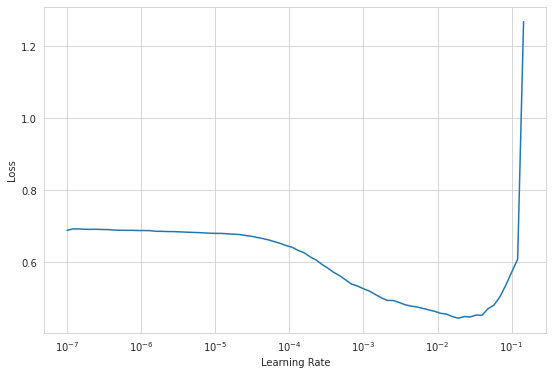

In [26]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [27]:
learn.fit_one_cycle(5, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.211683,0.200731,0.894971,0.319490,0.341360,0.457539,0.680985,0.170000,00:39
1,0.196371,0.201289,0.900571,0.355242,0.411680,0.471404,0.690170,0.140000,00:39
2,0.173049,0.183998,0.913371,0.378308,0.408277,0.431542,0.681244,0.250000,00:39
3,0.138433,0.171068,0.929029,0.428648,0.480681,0.360485,0.660767,0.390000,00:39
4,0.113141,0.166124,0.938286,0.445719,0.565344,0.282496,0.632301,0.520000,00:39


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.34136009406206114.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.41168047669041063.
Better model found at epoch 3 with precision_score value: 0.48068132312402706.
Better model found at epoch 4 with precision_score value: 0.5653440966976201.


(1.2022644114040304e-06, 6.309573450380412e-07)

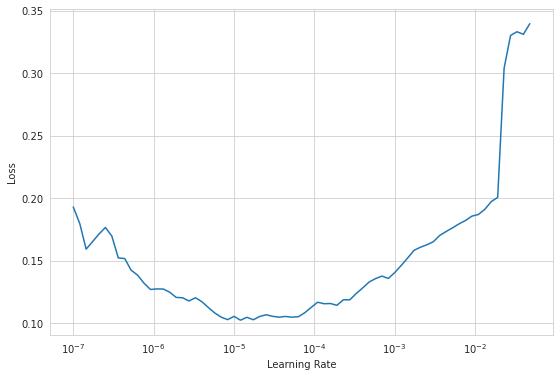

In [28]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [29]:
learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.110234,0.166088,0.936229,0.447174,0.530913,0.320624,0.647962,0.470000,01:10
1,0.106366,0.166285,0.930629,0.444387,0.470641,0.403813,0.681605,0.360000,01:09
2,0.108115,0.166275,0.930057,0.444080,0.463795,0.412478,0.685162,0.350000,01:10
3,0.108549,0.165935,0.927086,0.442344,0.450732,0.445407,0.697536,0.310000,01:10
4,0.104585,0.165948,0.929029,0.443124,0.458263,0.424610,0.689734,0.340000,01:09
5,0.103833,0.166428,0.930972,0.442563,0.471756,0.391681,0.676467,0.370000,01:09
6,0.105811,0.166333,0.935429,0.443243,0.520940,0.325823,0.649860,0.460000,01:10
7,0.106304,0.166211,0.928114,0.439881,0.452624,0.428076,0.690680,0.330000,01:10
8,0.107796,0.166255,0.928457,0.441977,0.455415,0.428076,0.691051,0.330000,01:10
9,0.101219,0.166264,0.931771,0.439079,0.479956,0.367418,0.666036,0.400000,01:10


In [30]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.39999999999999986

In [31]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/saw/models/exp_cls_multilabel_hf.pth')

Export model for inference

In [32]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [33]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [34]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.1661239117383957,
 'accuracy_multi': 0.9313141703605652,
 'fbeta_score': 0.4278868410602639,
 'precision_score': 0.46554531057092596,
 'recall_score': 0.36395147313691506,
 'roc_auc_score': 0.6639405027906756,
 'opt_th': 0.39999999999999986}

In [35]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [36]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [37]:
inf_learn.loss_func.thresh

0.39999999999999986

In [38]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

((#1) ['benefits'],
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([1.8711e-02, 5.2474e-03, 3.5745e-03, 8.2843e-01, 3.2721e-04, 3.8389e-03,
         5.7669e-04, 4.1042e-04, 2.1067e-02, 4.7867e-04, 8.9806e-04, 1.6499e-03,
         1.4749e-03, 9.0529e-05, 2.1876e-01, 2.0863e-02, 1.3580e-03, 1.9554e-04,
         3.4877e-04, 3.4162e-03, 1.0258e-03, 3.7719e-03, 3.9020e-01, 1.1785e-02,
         1.6657e-02]))

Review final validation loss for best model

In [39]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [40]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [41]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.1661239117383957


In [42]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

((#1) ['faculty_value_contributions'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([2.0927e-02, 3.0174e-03, 2.9878e-03, 2.5454e-04, 1.8175e-01, 4.6914e-04,
         1.8358e-03, 1.5500e-04, 2.2189e-01, 3.3072e-04, 3.4682e-02, 7.1181e-04,
         6.0324e-01, 4.0140e-04, 1.1520e-03, 3.2242e-01, 2.0221e-04, 1.6202e-03,
         6.5302e-05, 7.2821e-02, 1.2774e-03, 3.3169e-04, 2.0439e-03, 3.1249e-02,
         8.6133e-03]))

## Review

### Lets look at validation metrics

In [43]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(torch.Size([350, 25]), torch.Size([350, 25]), 350, 25, 0.39999999999999986)

In [44]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [45]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.37000000000000005, 0.16000000000000003, 0.060000000000000005)

In [46]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.44564228742603335, 0.458695514826174, 0.5811661835605365)

In [47]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=.5, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.44564228742603335

In [48]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9307428598403931, 0.9001142978668213, 0.8288000226020813)

In [49]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9307428598403931

### Overall metrics

In [50]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [51]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.24285714285714285


In [52]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9307428571428571


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [53]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 8173


In [54]:
most_freq_class_count / len(eval_targs)

0.9340571428571428

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [55]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.39700313114866326


#### Confusion Matrix

Describes the performance of a classification model

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [57]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

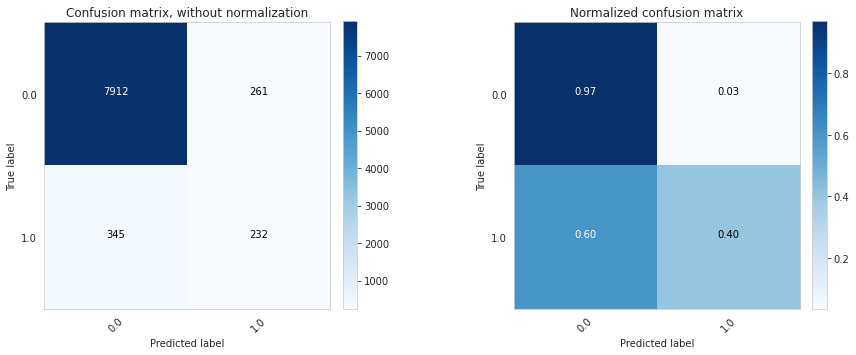

In [58]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [59]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

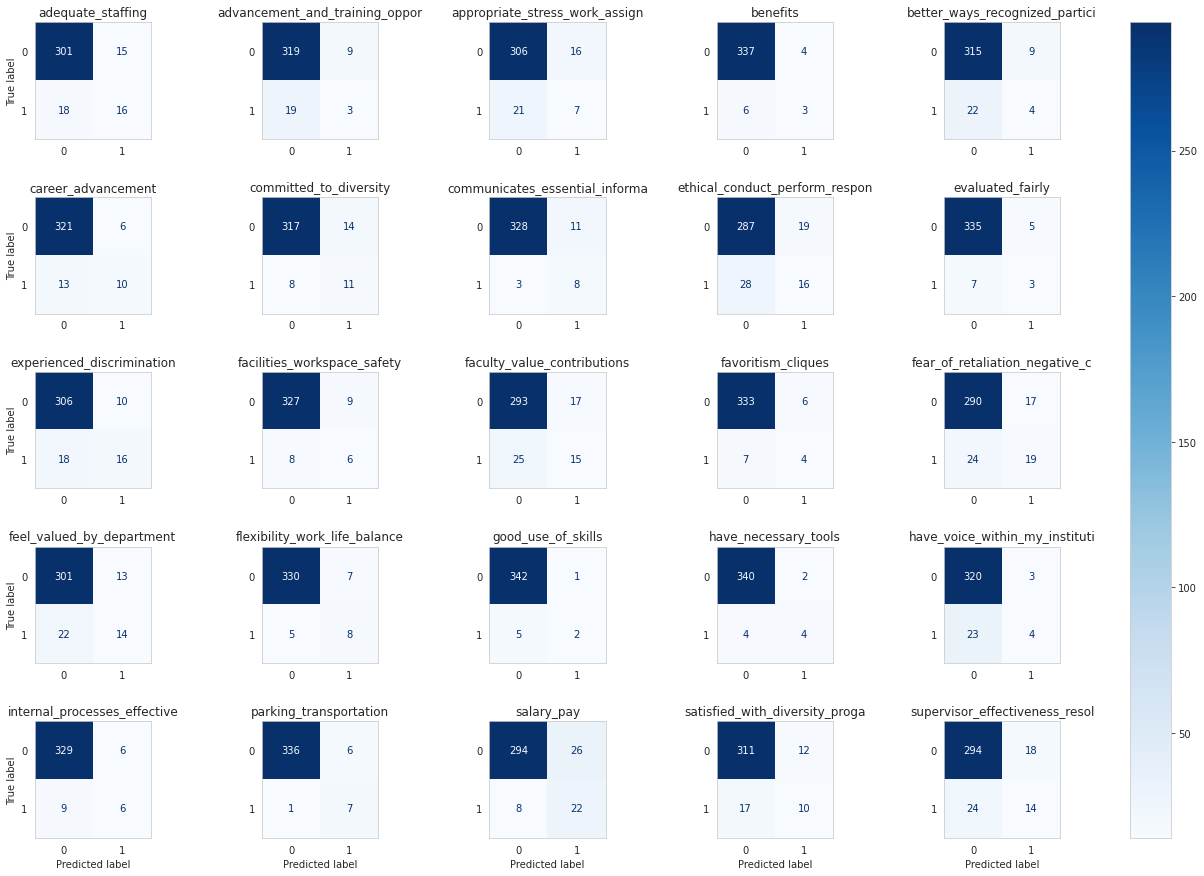

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(5, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(25):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_SAW_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [61]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8173
           1       0.47      0.40      0.43       577

    accuracy                           0.93      8750
   macro avg       0.71      0.69      0.70      8750
weighted avg       0.93      0.93      0.93      8750



In [62]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_SAW_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
adequate_staffing,0.516129,0.470588,0.492308,34.0
advancement_and_training_opportunities,0.250000,0.136364,0.176471,22.0
appropriate_stress_work_assigned_equitably,0.304348,0.250000,0.274510,28.0
benefits,0.428571,0.333333,0.375000,9.0
better_ways_recognized_participate_in_decisions,0.307692,0.153846,0.205128,26.0
career_advancement,0.625000,0.434783,0.512821,23.0
committed_to_diversity,0.440000,0.578947,0.500000,19.0
communicates_essential_information,0.421053,0.727273,0.533333,11.0
ethical_conduct_perform_responsibilities_spirit_of_cooperation,0.457143,0.363636,0.405063,44.0
evaluated_fairly,0.375000,0.300000,0.333333,10.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

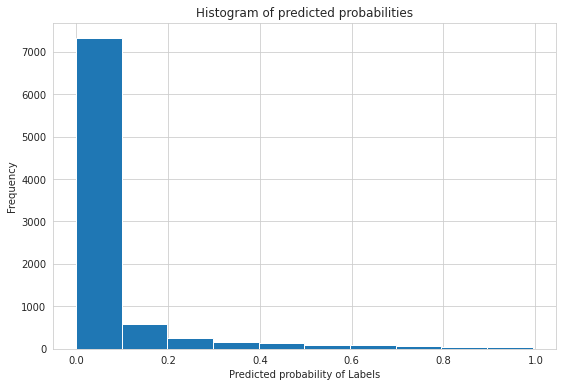

In [63]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [64]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

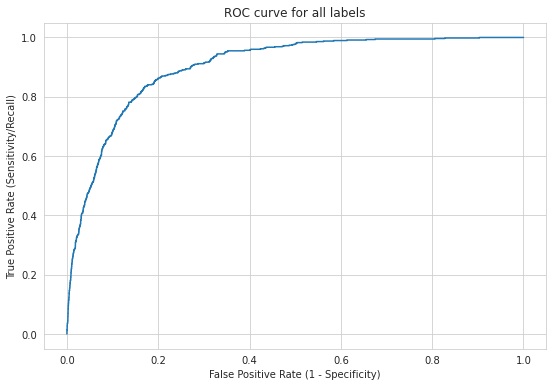

In [65]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [66]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9022046214222297


### Let's look at things by label by label

In [67]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [68]:
# label_metrics

ADEQUATE_STAFFING

Null Accuracy:	0.9028571428571428
AUC Score:	0.9124162323157111

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9057142857142857	0.8685714285714285	0.7885714285714286	
Cohen's Kappa:	0.4404611956205794	0.40651725154821583	0.38026416539050534	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9436              0.9525              0.948               316                 
1                   0.5161              0.4706              0.4923              34                  
avg/total           0.7299              0.7116              0.7202              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9561              0.8956              0.9248              316                 
1                   0.3889              0.6176              0.4773           

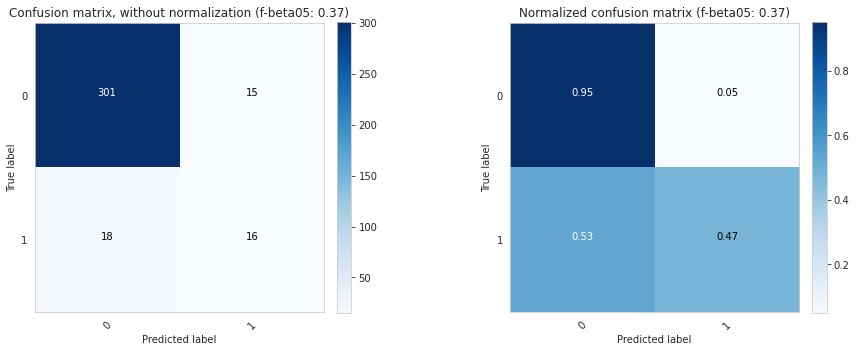

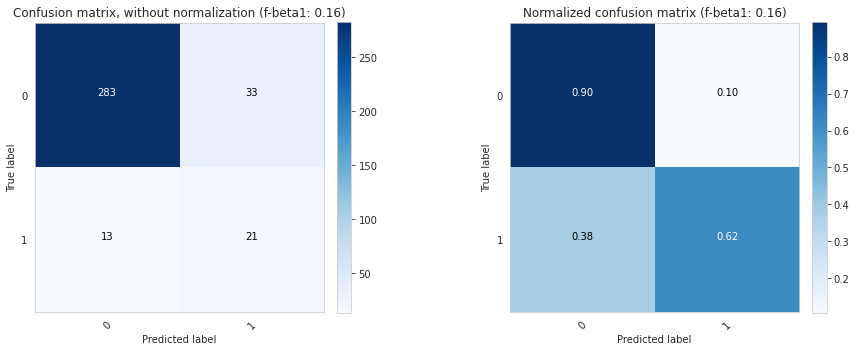

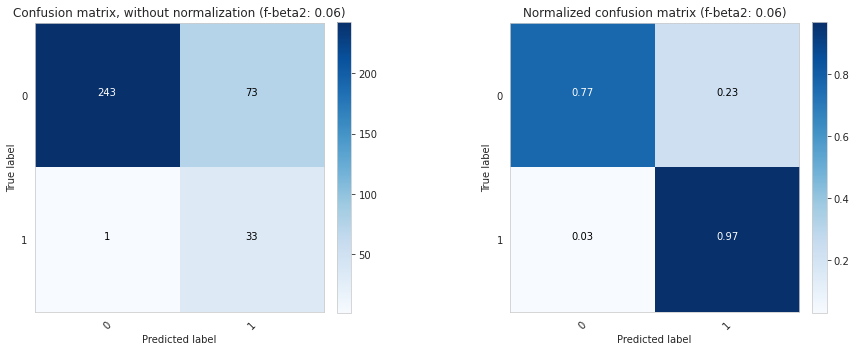



ROC Curve:


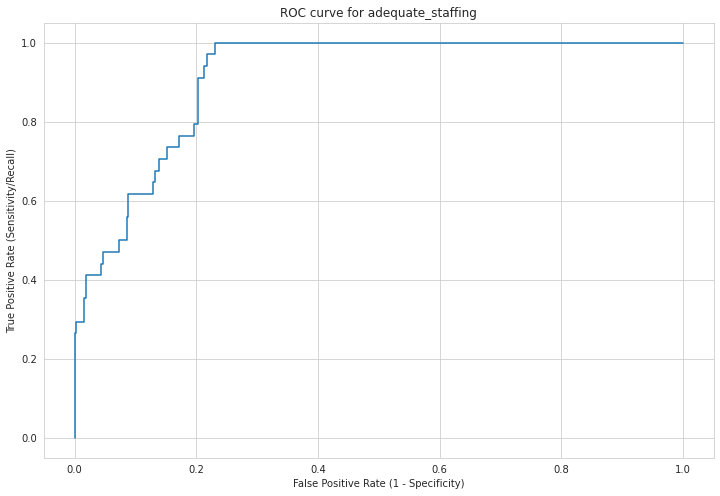

Predicted Probability Distribution:


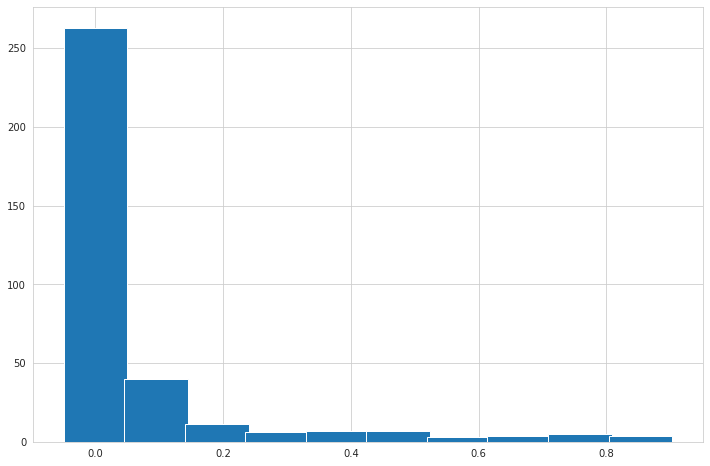



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9371428571428572
AUC Score:	0.8888580931263859

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.92	0.9257142857142857	0.8485714285714285	
Cohen's Kappa:	0.1382342595849455	0.497348652231551	0.32765494744472634	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9438              0.9726              0.958               328                 
1                   0.25                0.1364              0.1765              22                  
avg/total           0.5969              0.5545              0.5672              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9778              0.9421              0.9596  

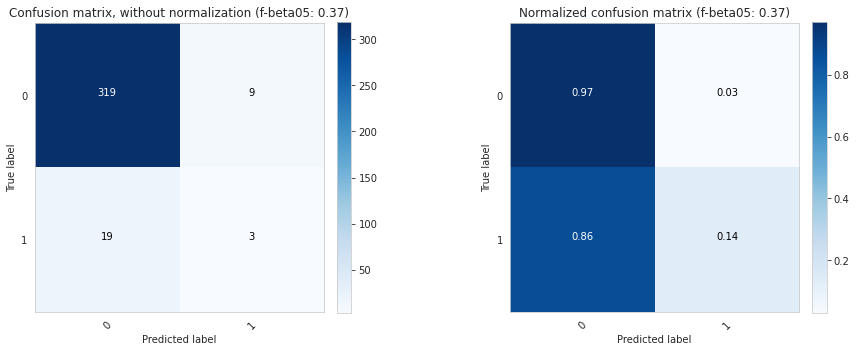

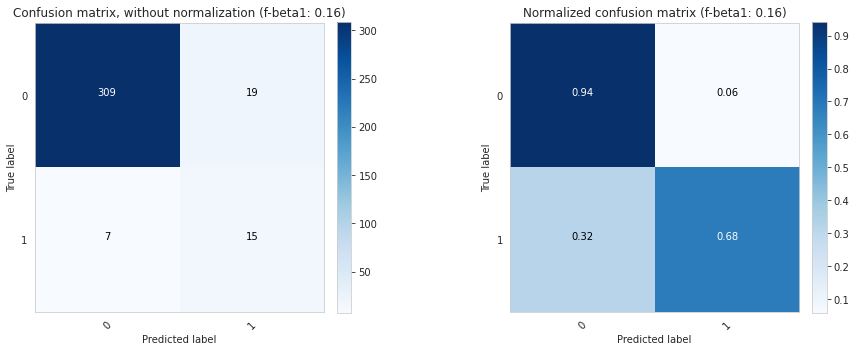

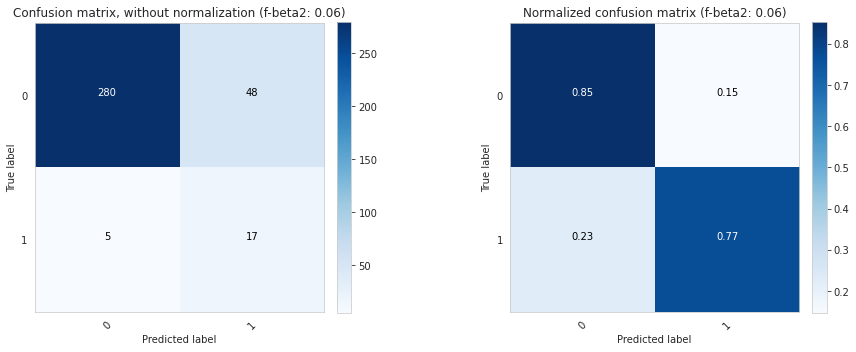



ROC Curve:


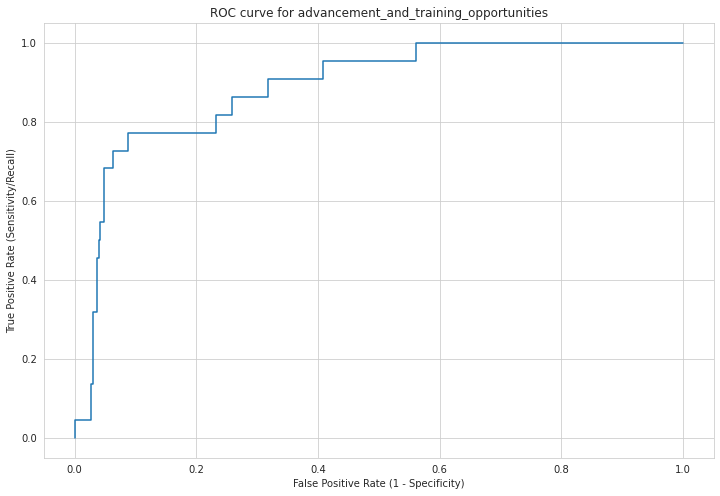

Predicted Probability Distribution:


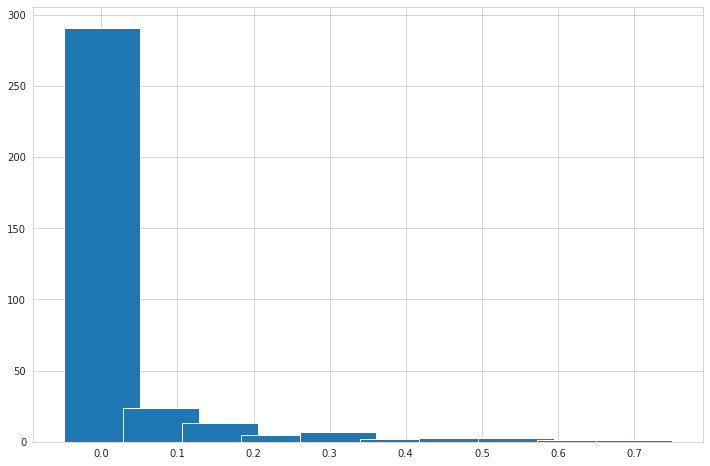



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.92
AUC Score:	0.8368456078083408

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.8942857142857142	0.8457142857142858	0.7657142857142857	
Cohen's Kappa:	0.21808960270498734	0.22857142857142854	0.2567077592458302	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9358              0.9503              0.943               322                 
1                   0.3043              0.25                0.2745              28                  
avg/total           0.6201              0.6002              0.6087              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9467              0.882               0.

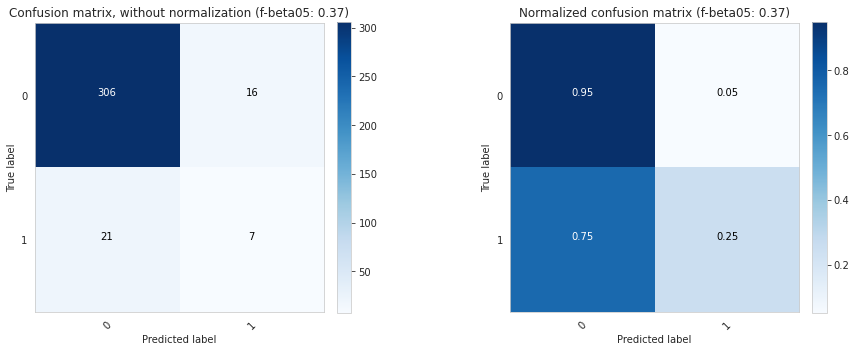

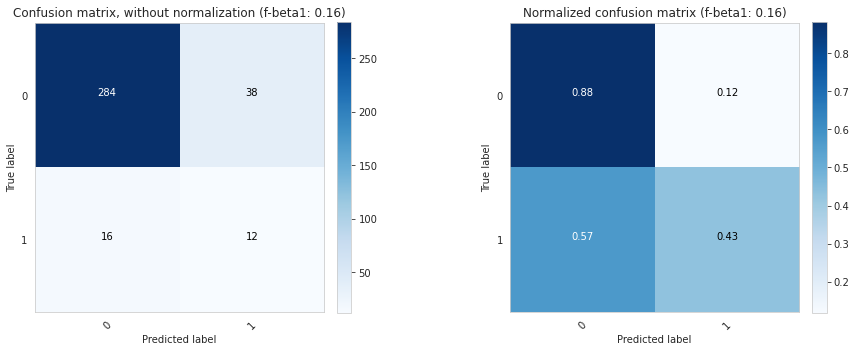

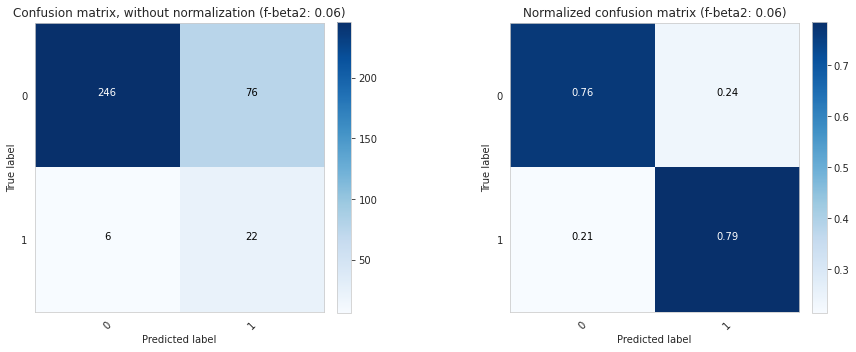



ROC Curve:


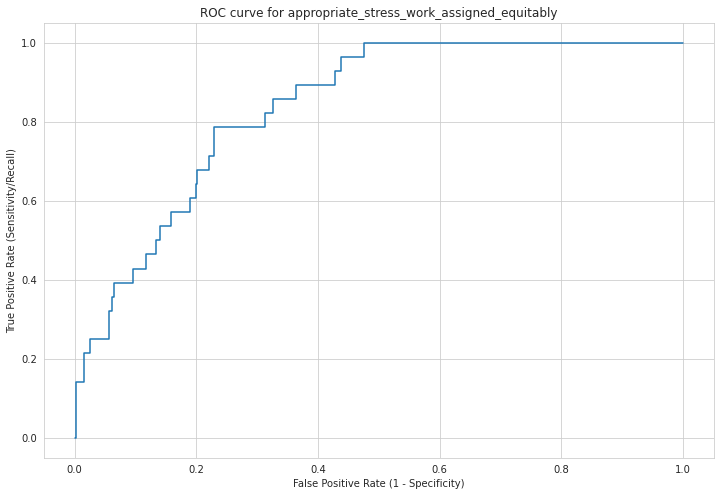

Predicted Probability Distribution:


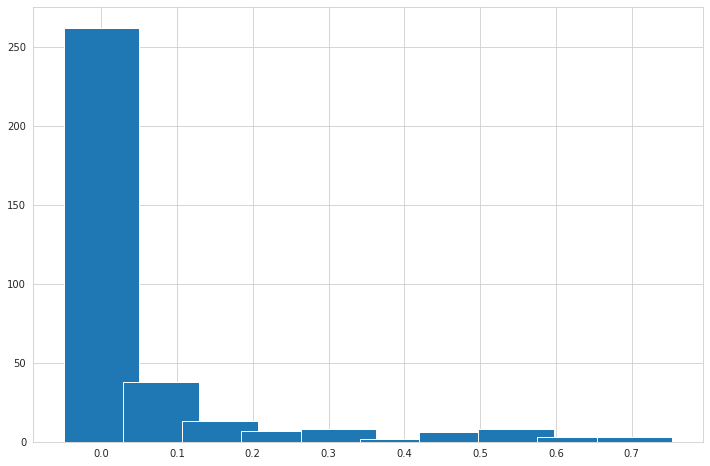



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9742857142857143
AUC Score:	0.9758879113717824

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9714285714285714	0.9771428571428571	0.96	
Cohen's Kappa:	0.36061381074168797	0.5883563657747721	0.481920067667583	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9825              0.9883              0.9854              341                 
1                   0.4286              0.3333              0.375               9                   
avg/total           0.7055              0.6608              0.6802              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9912              0.9853              0.9882              341               

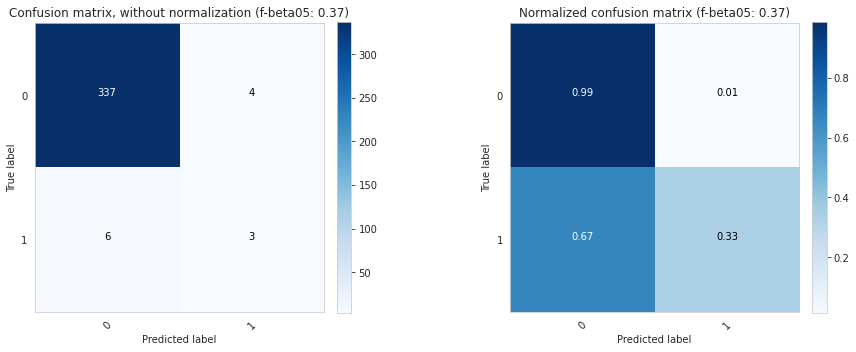

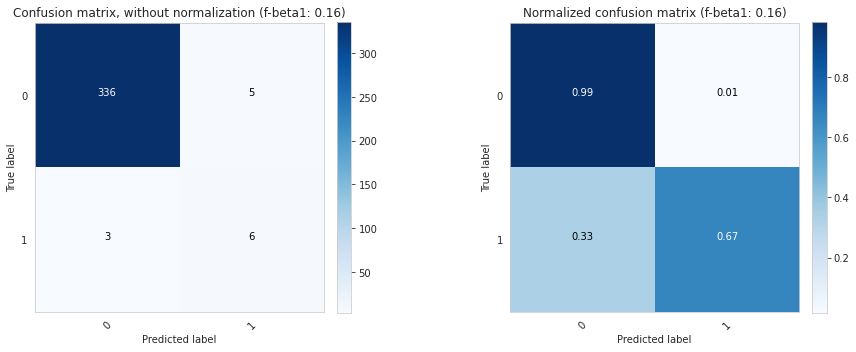

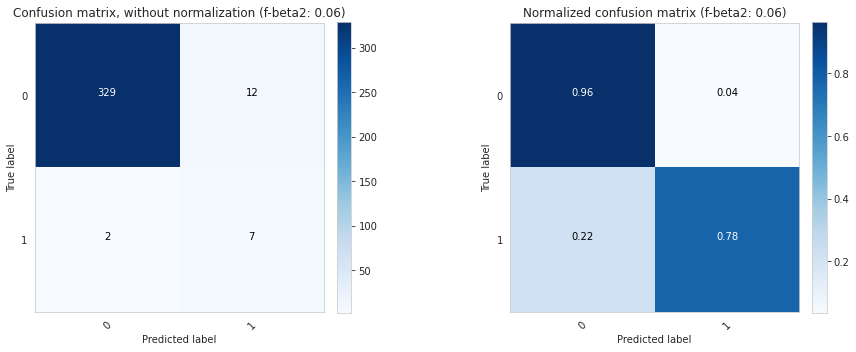



ROC Curve:


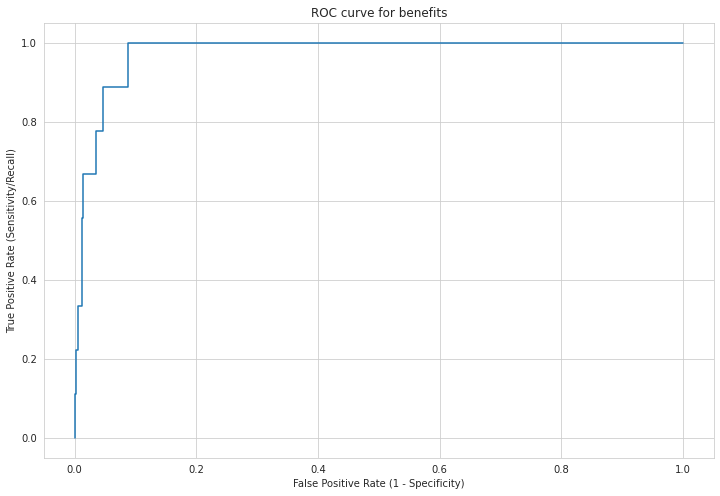

Predicted Probability Distribution:


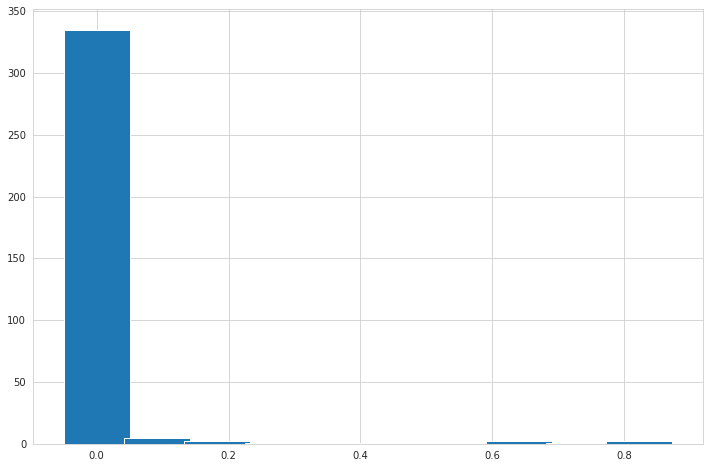



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.9257142857142857
AUC Score:	0.8301282051282052

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9114285714285715	0.8771428571428571	0.8142857142857143	
Cohen's Kappa:	0.1637120394635425	0.2940238296275449	0.3030451565467802	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9347              0.9722              0.9531              324                 
1                   0.3077              0.1538              0.2051              26                  
avg/total           0.6212              0.563               0.5791              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9547              0.910

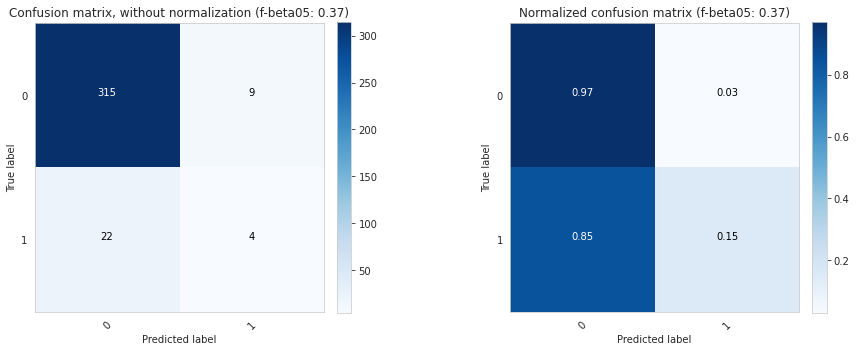

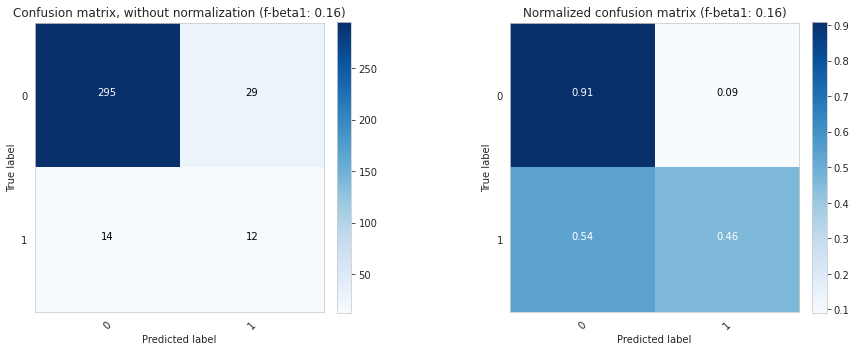

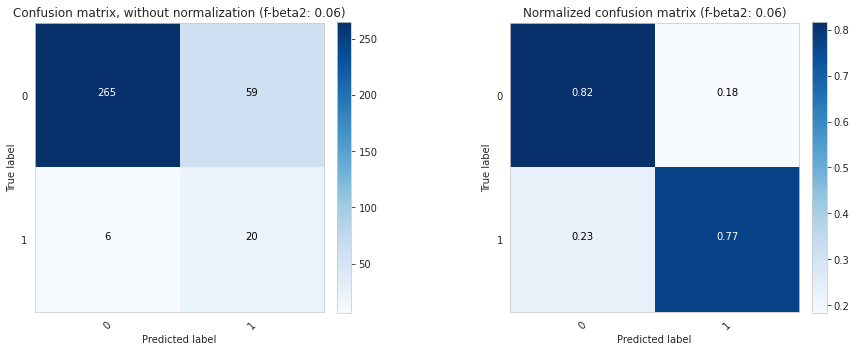



ROC Curve:


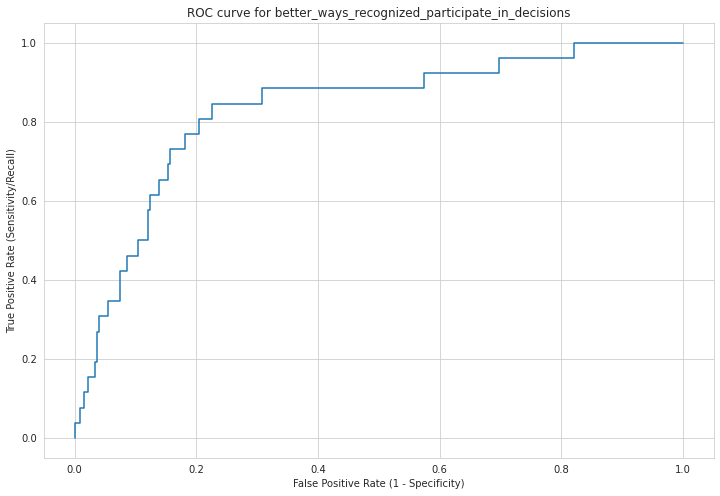

Predicted Probability Distribution:


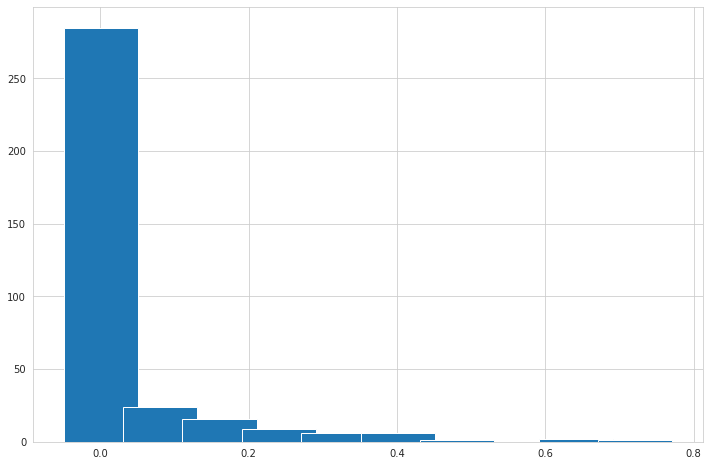



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.9342857142857143
AUC Score:	0.9172982316181358

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9457142857142857	0.9057142857142857	0.8257142857142857	
Cohen's Kappa:	0.48505497909245787	0.4107744107744108	0.32781311000566726	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9611              0.9817              0.9713              327                 
1                   0.625               0.4348              0.5128              23                  
avg/total           0.793               0.7082              0.742               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9712              0.9266              0.9484      

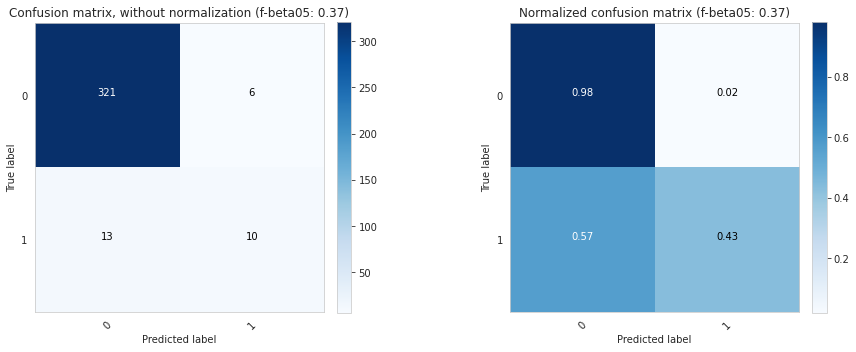

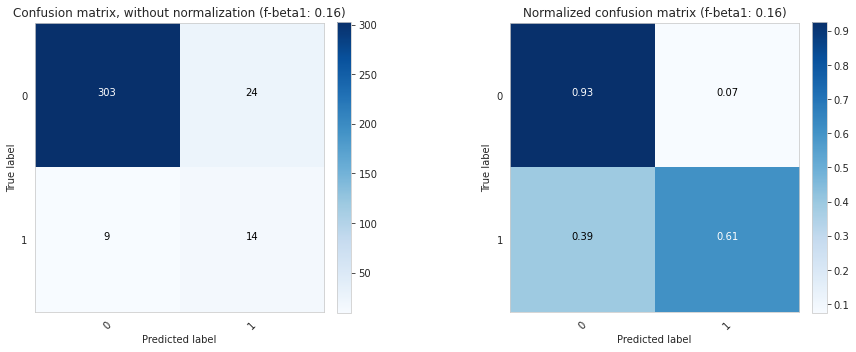

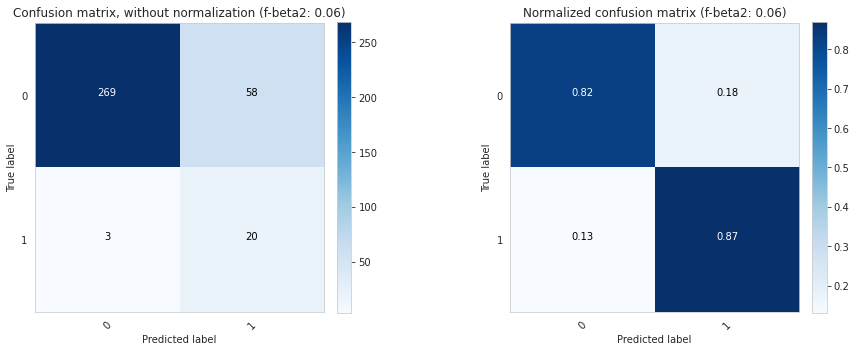



ROC Curve:


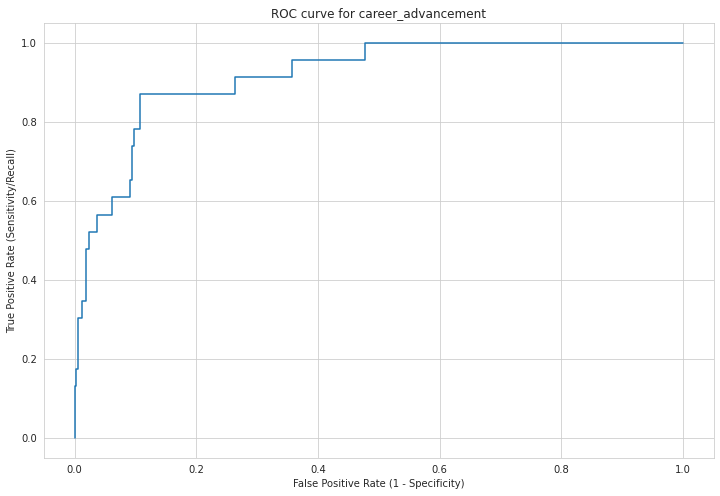

Predicted Probability Distribution:


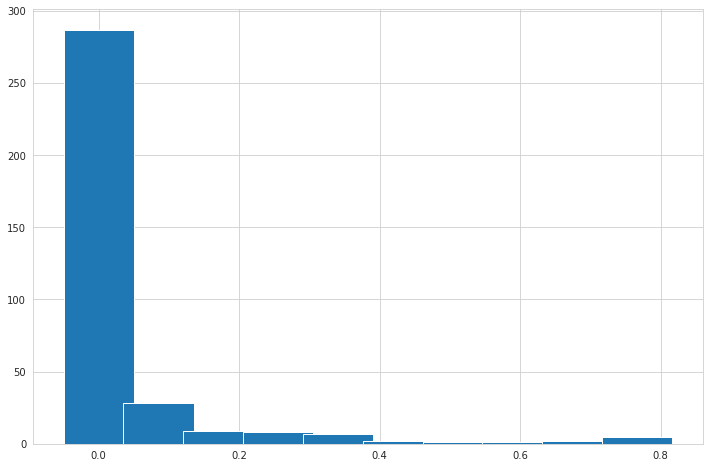



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9457142857142857
AUC Score:	0.8863094291620289

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9371428571428572	0.8828571428571429	0.8085714285714286	
Cohen's Kappa:	0.46712802768166084	0.33644686950892444	0.24320660943651962	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9754              0.9577              0.9665              331                 
1                   0.44                0.5789              0.5                 19                  
avg/total           0.7077              0.7683              0.7332              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9801              0.8943              0.9352 

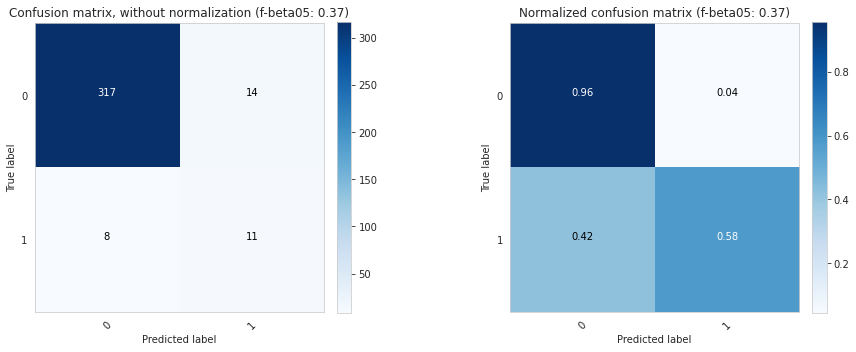

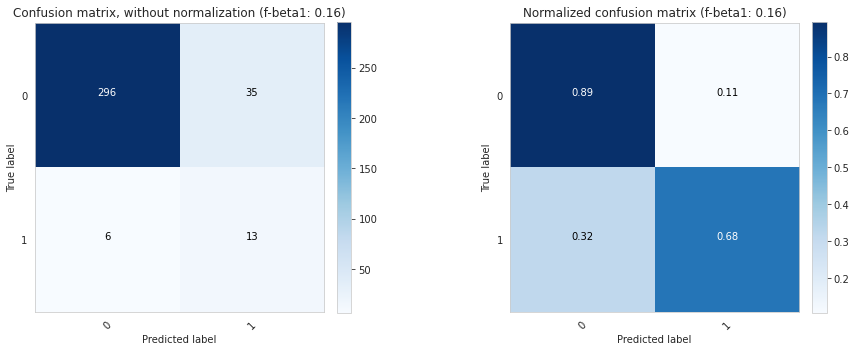

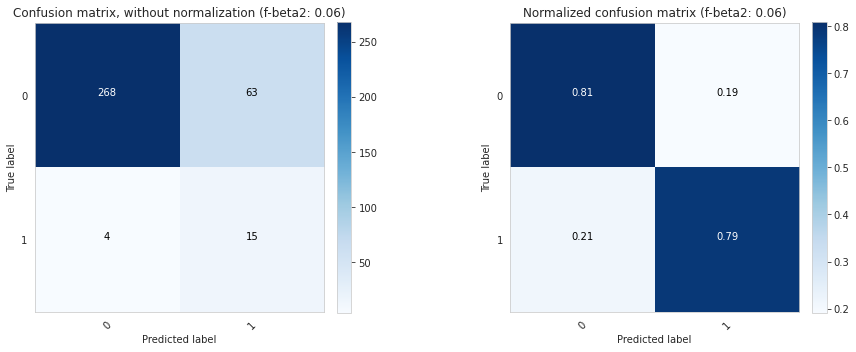



ROC Curve:


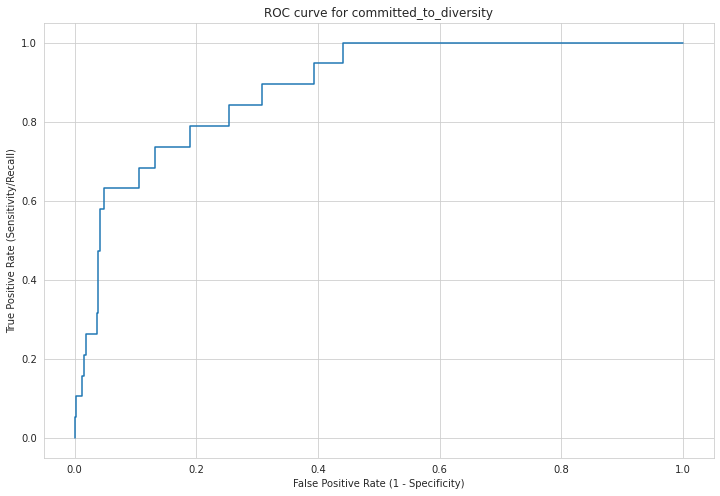

Predicted Probability Distribution:


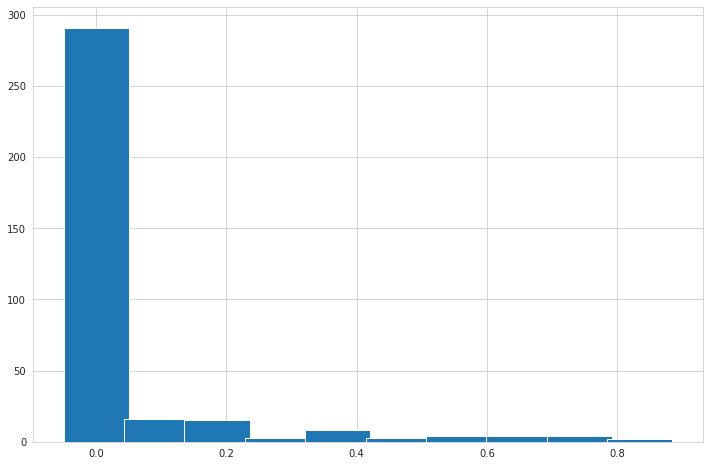



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9685714285714285
AUC Score:	0.9605792437650844

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.96	0.9457142857142857	0.9142857142857143	
Cohen's Kappa:	0.5139853203729419	0.4326906671216516	0.36906621800264405	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9909              0.9676              0.9791              339                 
1                   0.4211              0.7273              0.5333              11                  
avg/total           0.706               0.8474              0.7562              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9908              0.9528              0.9714     

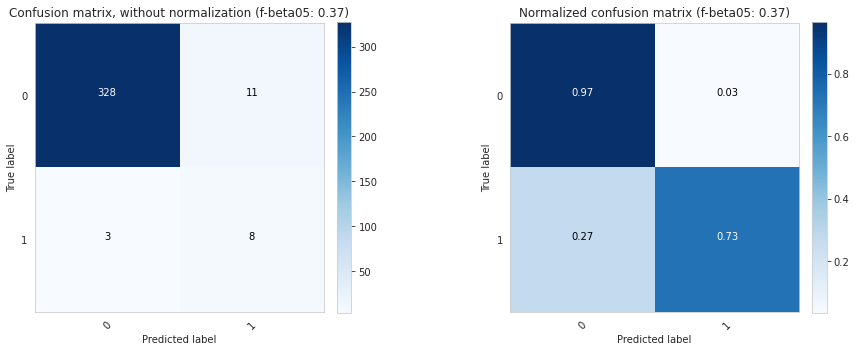

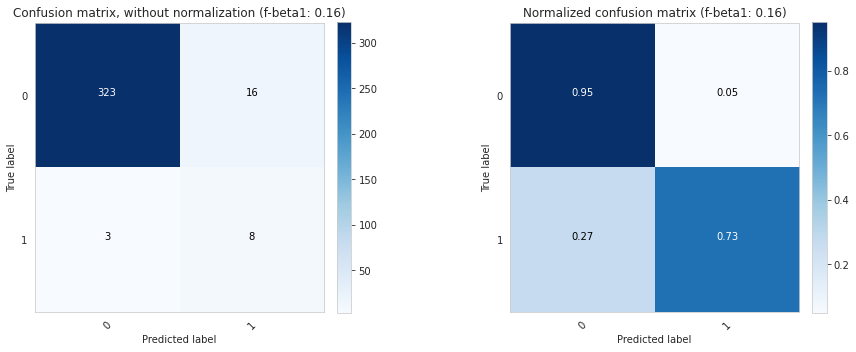

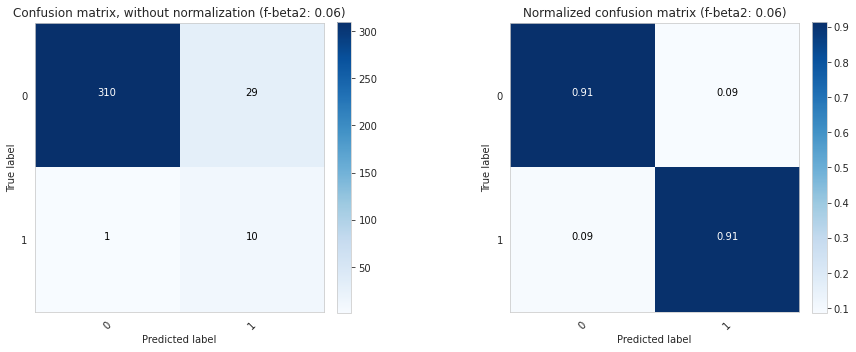



ROC Curve:


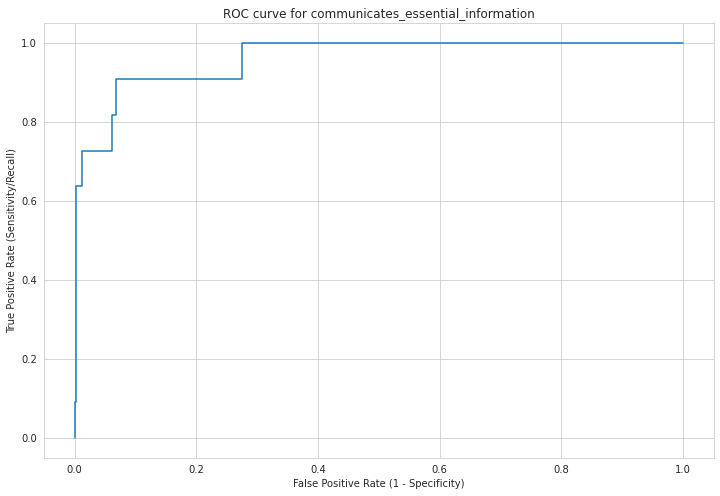

Predicted Probability Distribution:


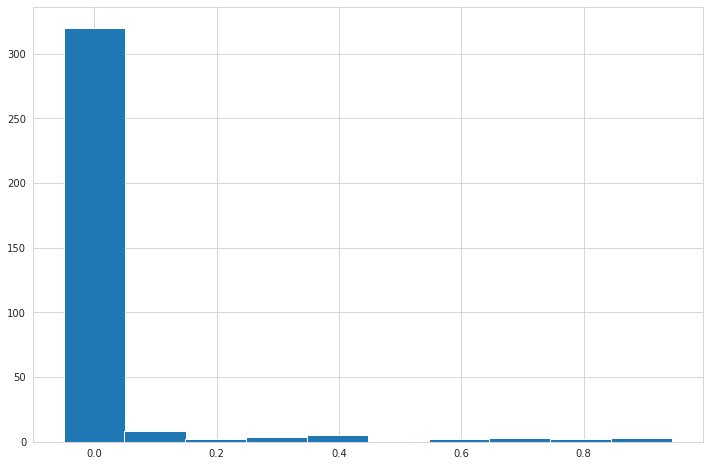



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.8742857142857143
AUC Score:	0.7999851455733809

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.8657142857142858	0.7457142857142857	0.5428571428571428	
Cohen's Kappa:	0.33048433048433046	0.29136903407798354	0.1610738255033558	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9111              0.9379              0.9243              306                 
1                   0.4571              0.3636              0.4051              44                  
avg/total           0.6841              0.6508              0.6647              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9502  

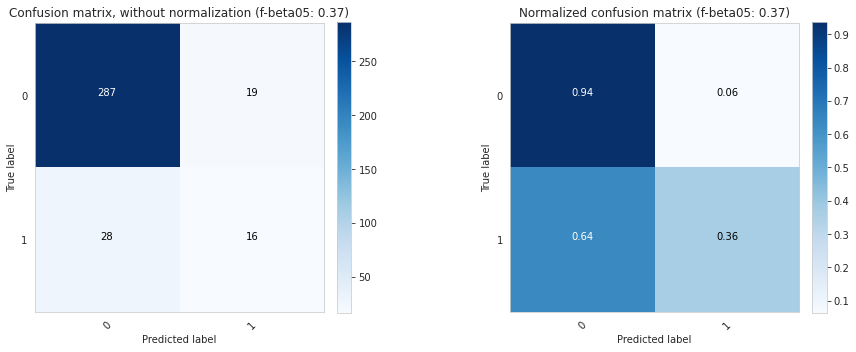

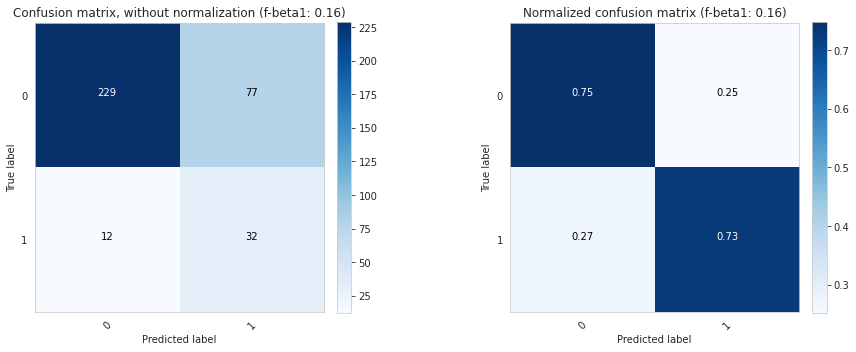

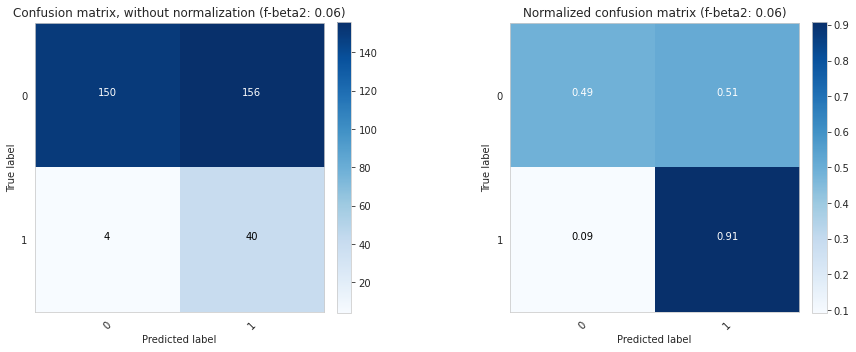



ROC Curve:


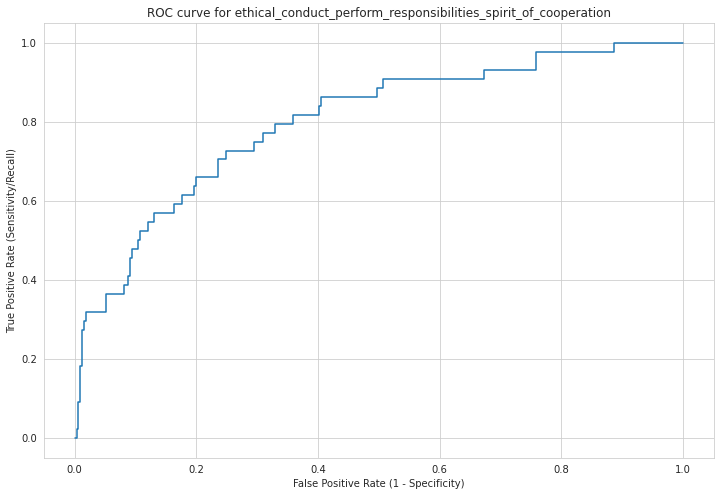

Predicted Probability Distribution:


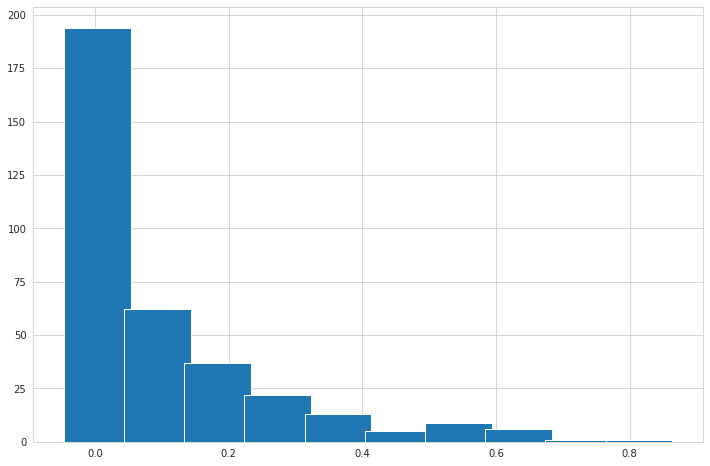



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9714285714285714
AUC Score:	0.89

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9657142857142857	0.9485714285714286	0.8942857142857142	
Cohen's Kappa:	0.3159609120521173	0.22413793103448276	0.20891875381795966	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9795              0.9853              0.9824              340                 
1                   0.375               0.3                 0.3333              10                  
avg/total           0.6773              0.6426              0.6579              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9792              0.9676              0.9734              340     

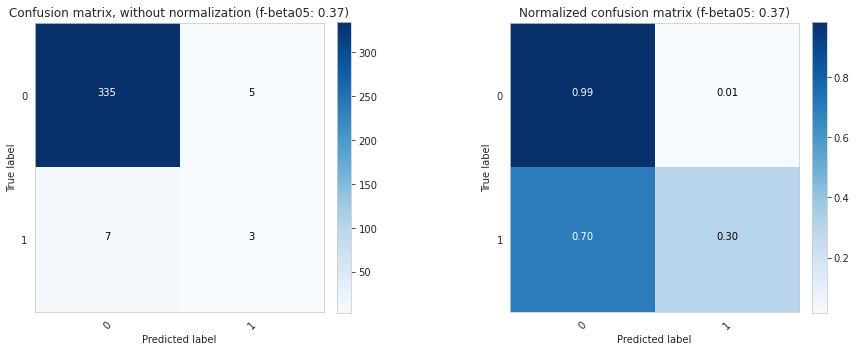

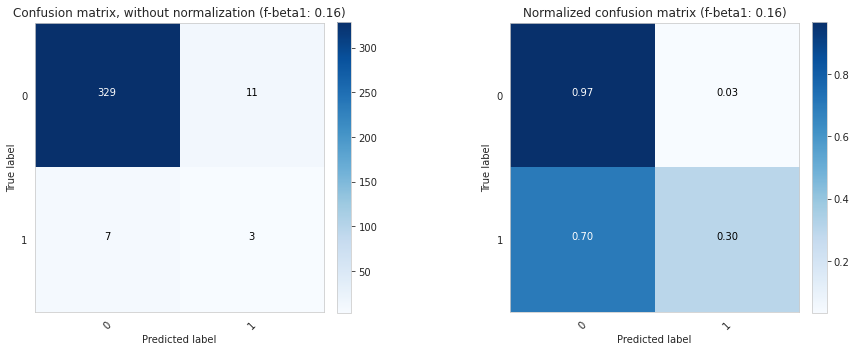

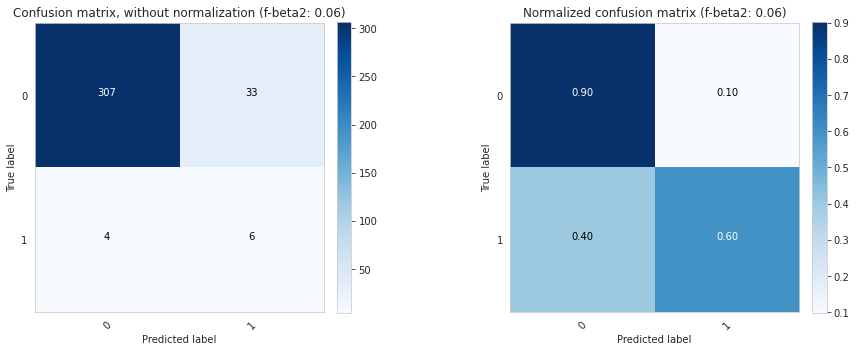



ROC Curve:


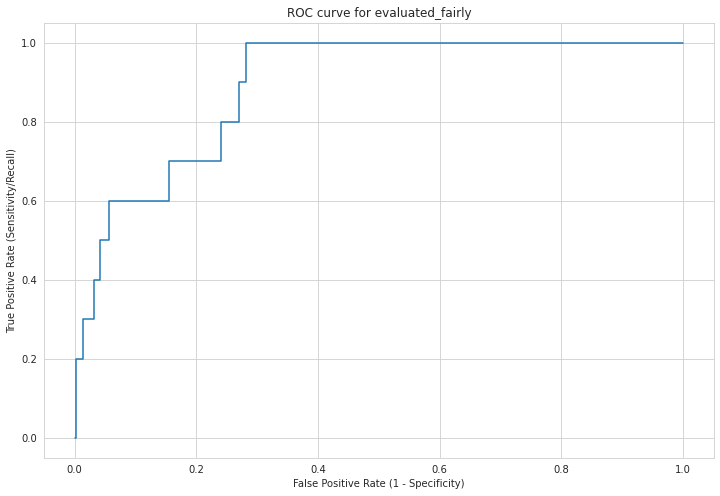

Predicted Probability Distribution:


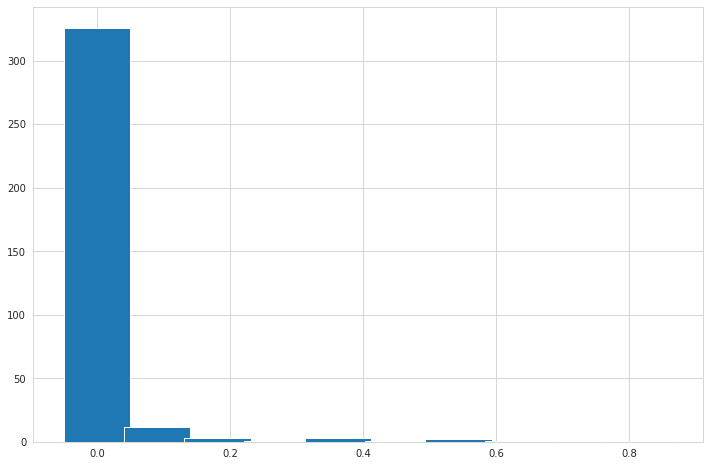



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.9028571428571428
AUC Score:	0.922933730454207

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.92	0.8971428571428571	0.82	
Cohen's Kappa:	0.490432612312812	0.5153846153846154	0.39479606960531377	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9444              0.9684              0.9562              316                 
1                   0.6154              0.4706              0.5333              34                  
avg/total           0.7799              0.7195              0.7448              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9667              0.9177              0.9416              316            

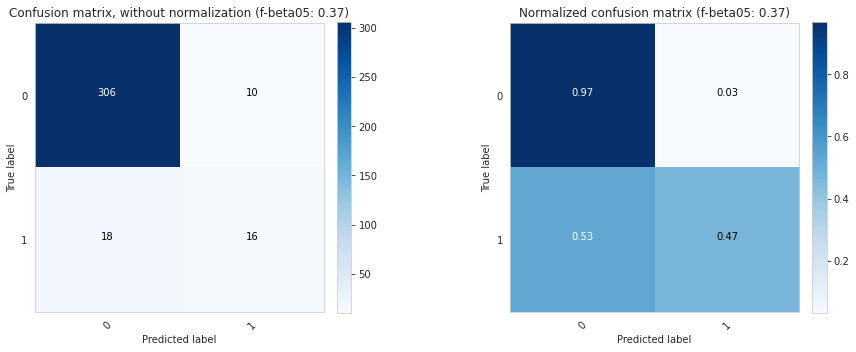

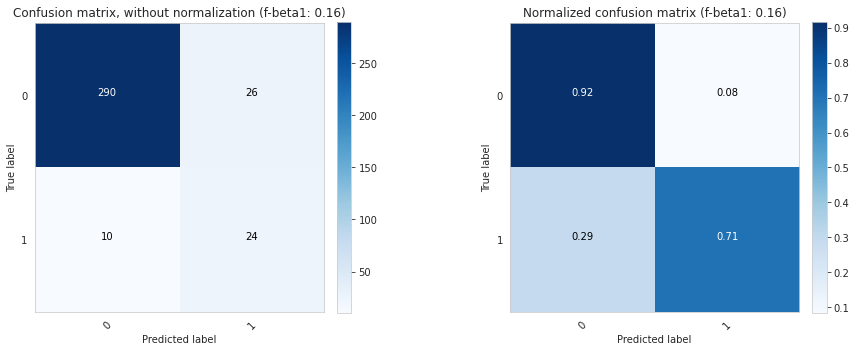

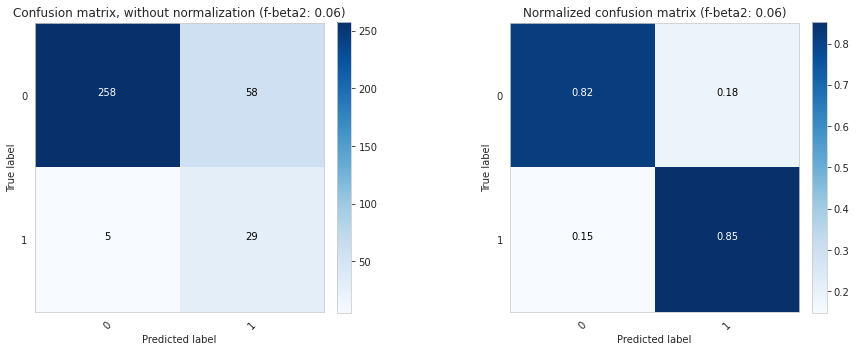



ROC Curve:


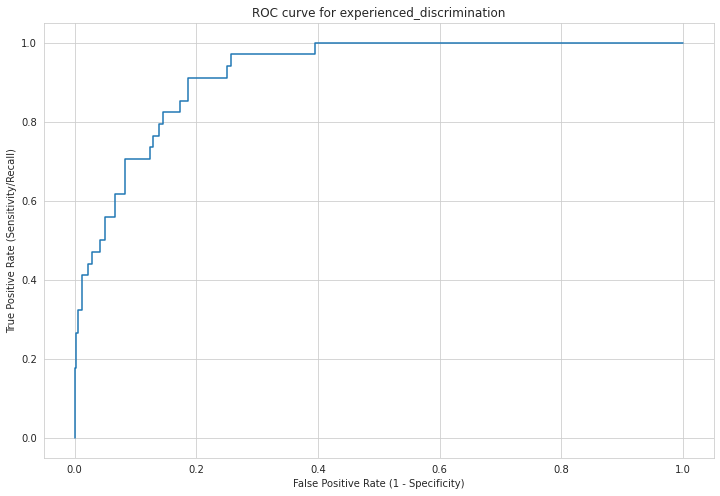

Predicted Probability Distribution:


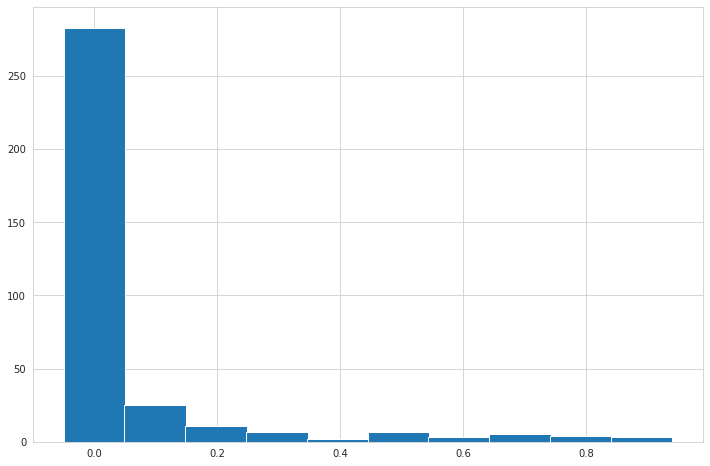



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.96
AUC Score:	0.9136904761904763

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9514285714285714	0.9428571428571428	0.9	
Cohen's Kappa:	0.38848920863309355	0.4158878504672897	0.34652725914861837	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9761              0.9732              0.9747              336                 
1                   0.4                 0.4286              0.4138              14                  
avg/total           0.6881              0.7009              0.6942              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9817              0.9583              0.9699              336         

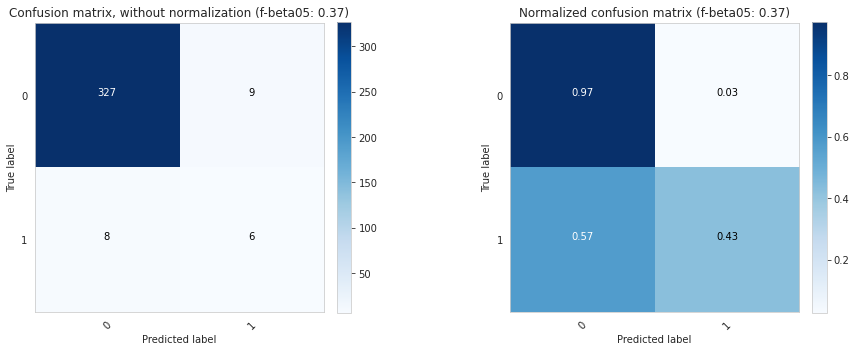

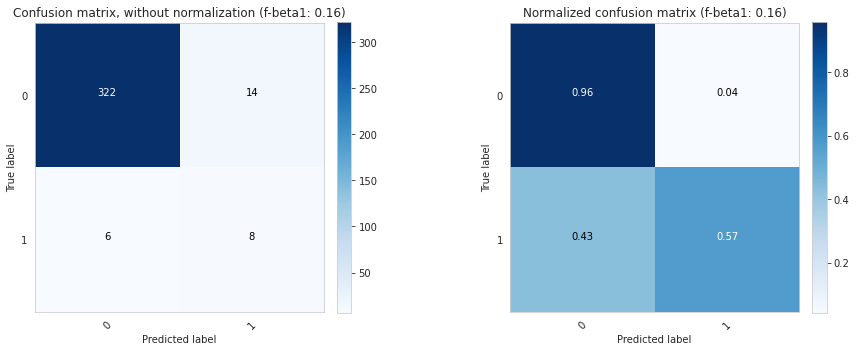

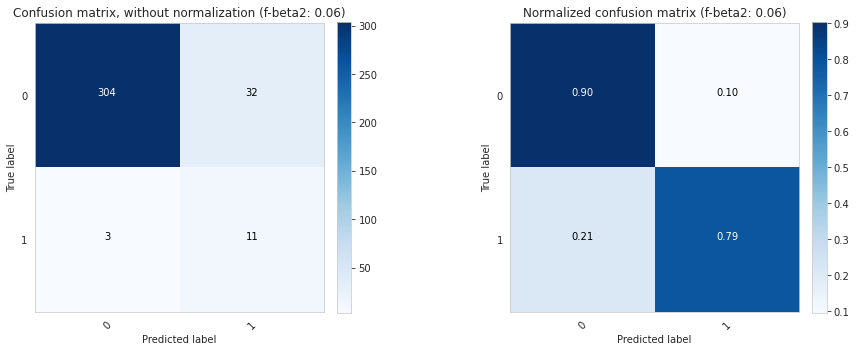



ROC Curve:


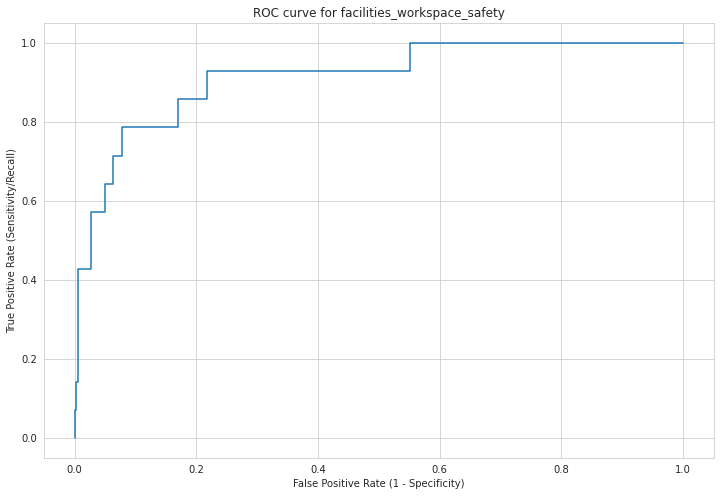

Predicted Probability Distribution:


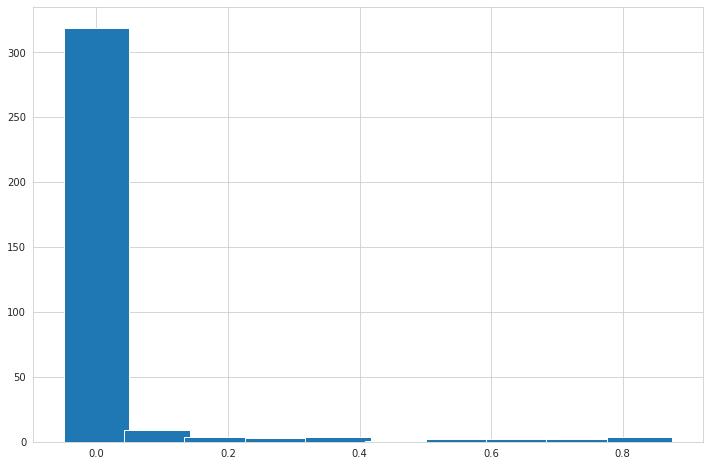



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.8857142857142857
AUC Score:	0.8533870967741934

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.88	0.8457142857142858	0.7371428571428571	
Cohen's Kappa:	0.35070671378091867	0.4348086124401914	0.31401789518534307	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9214              0.9452              0.9331              310                 
1                   0.4688              0.375               0.4167              40                  
avg/total           0.6951              0.6601              0.6749              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9604              0.8613              0.9082           

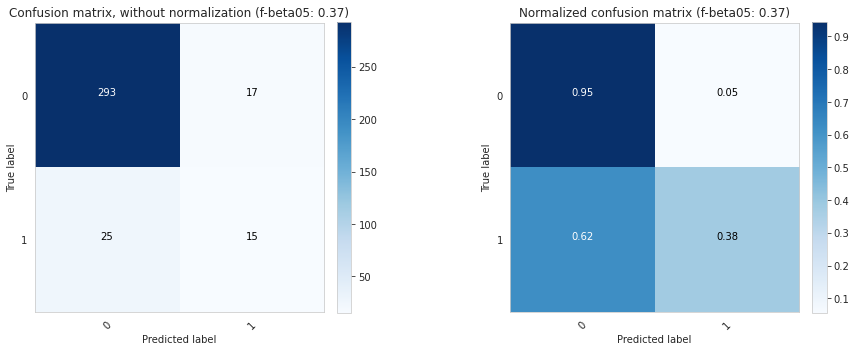

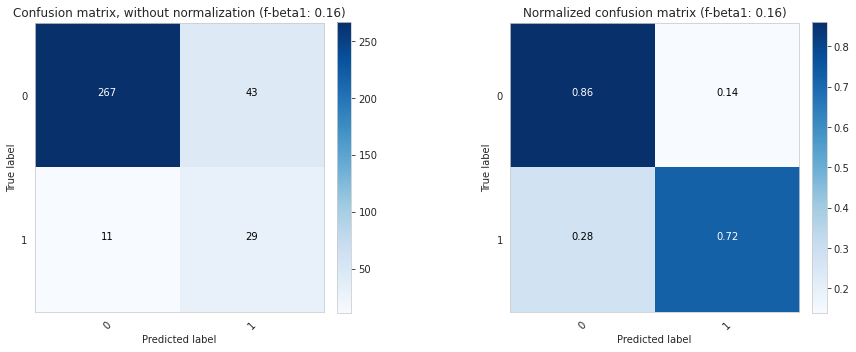

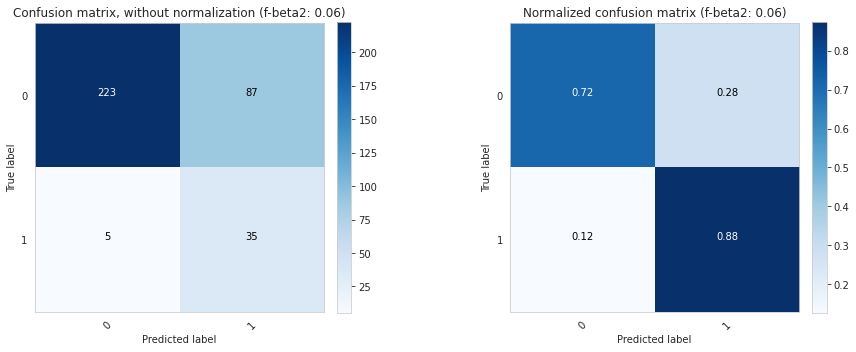



ROC Curve:


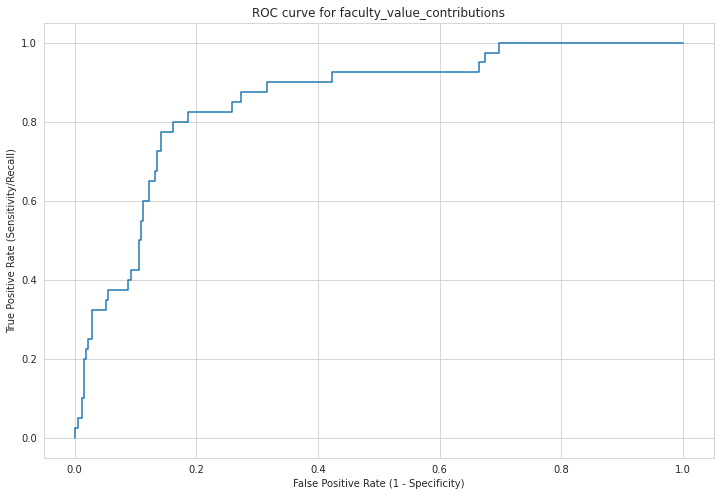

Predicted Probability Distribution:


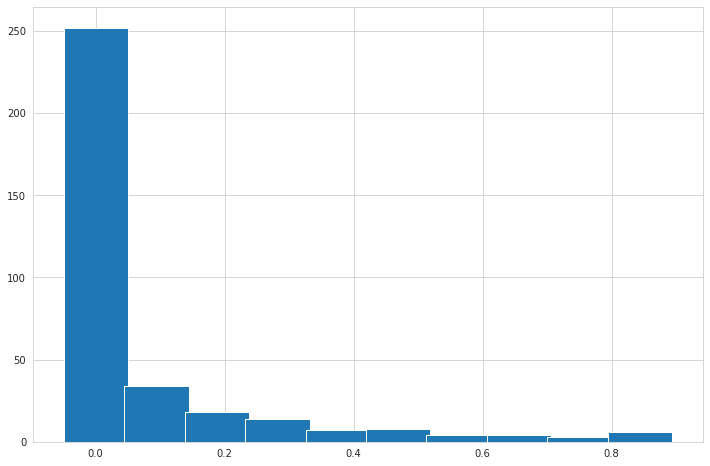



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9685714285714285
AUC Score:	0.8844194153928667

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9628571428571429	0.9571428571428572	0.94	
Cohen's Kappa:	0.3618513323983169	0.4229500989228402	0.43609022556390975	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9794              0.9823              0.9809              339                 
1                   0.4                 0.3636              0.381               11                  
avg/total           0.6897              0.673               0.6809              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.985               0.9705              0.9777              339    

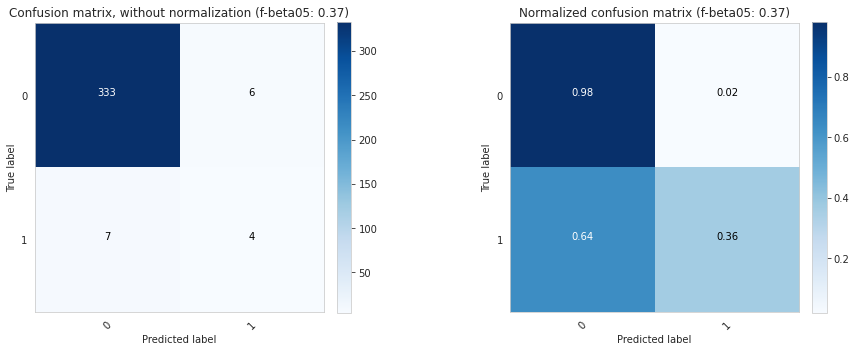

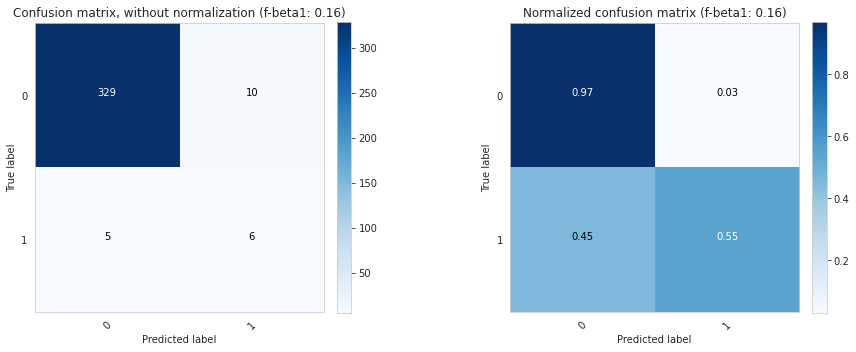

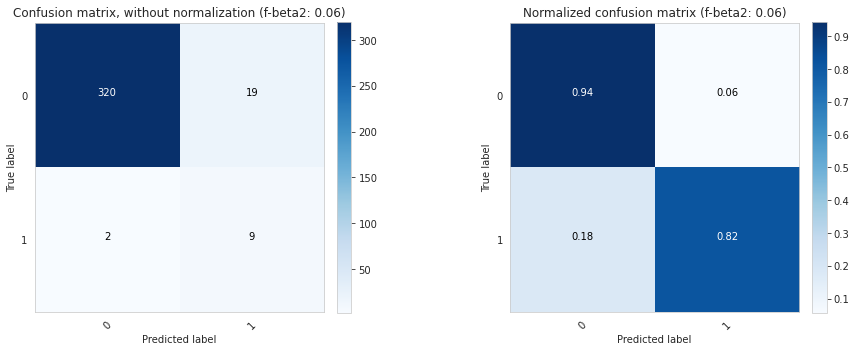



ROC Curve:


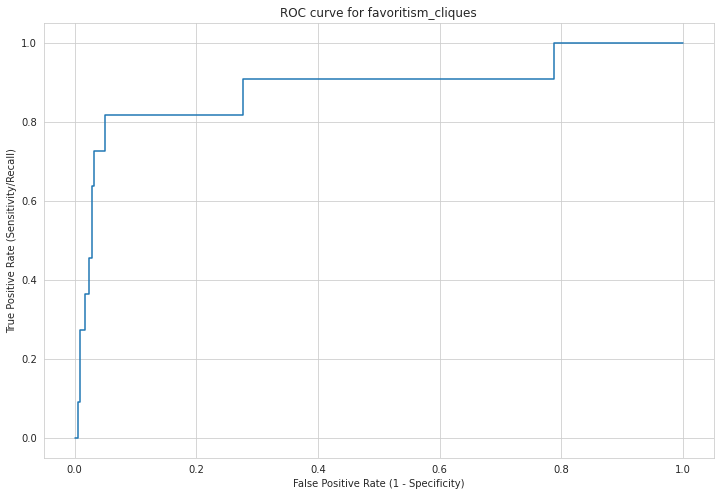

Predicted Probability Distribution:


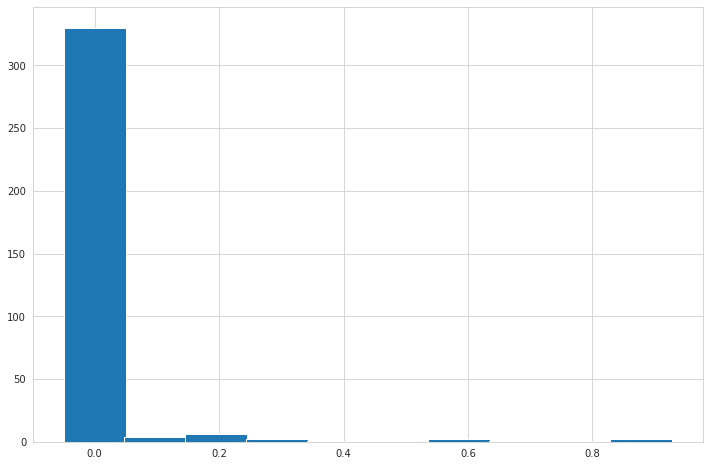



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.8771428571428571
AUC Score:	0.9020528747822135

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.8828571428571429	0.8771428571428571	0.8114285714285714	
Cohen's Kappa:	0.41557383725665886	0.5511482254697286	0.4391298013888214	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9236              0.9446              0.934               307                 
1                   0.5278              0.4419              0.481               43                  
avg/total           0.7257              0.6932              0.7075              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9714              0.886     

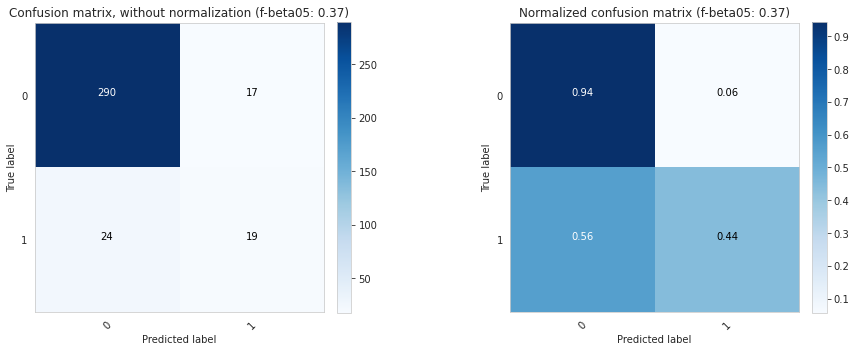

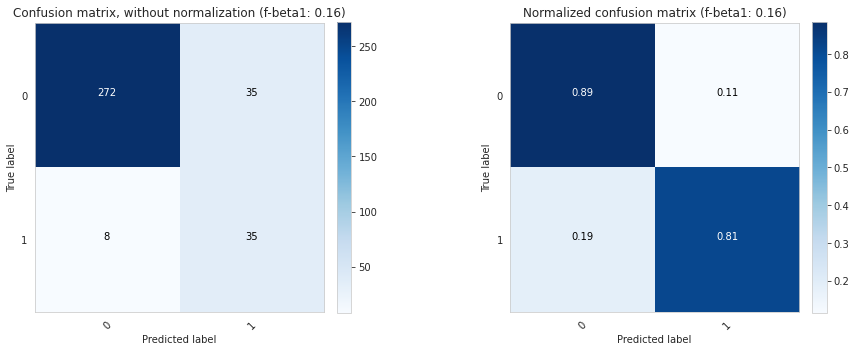

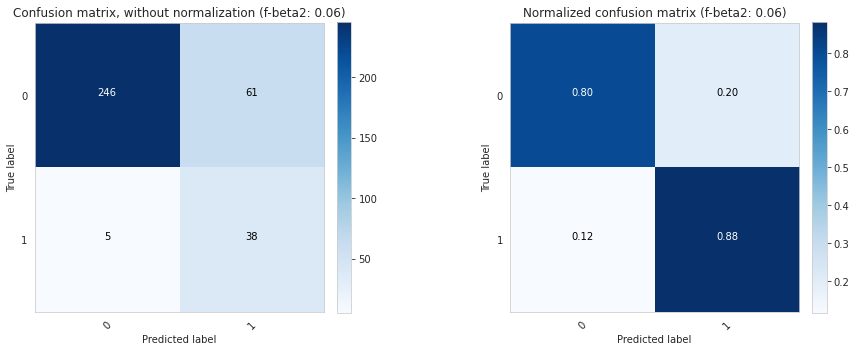



ROC Curve:


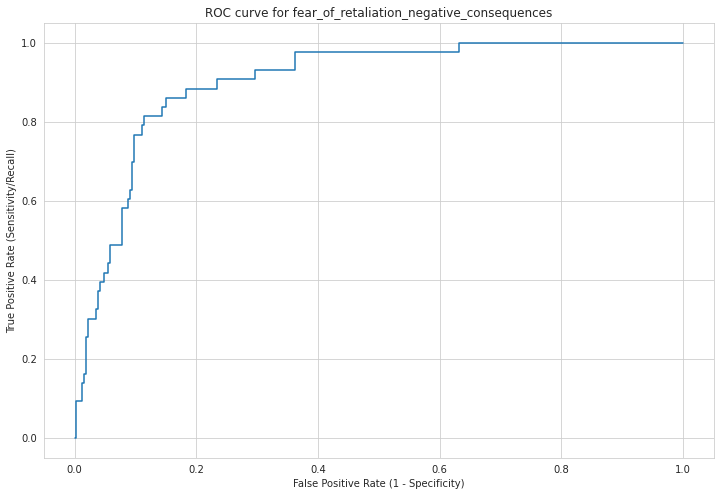

Predicted Probability Distribution:


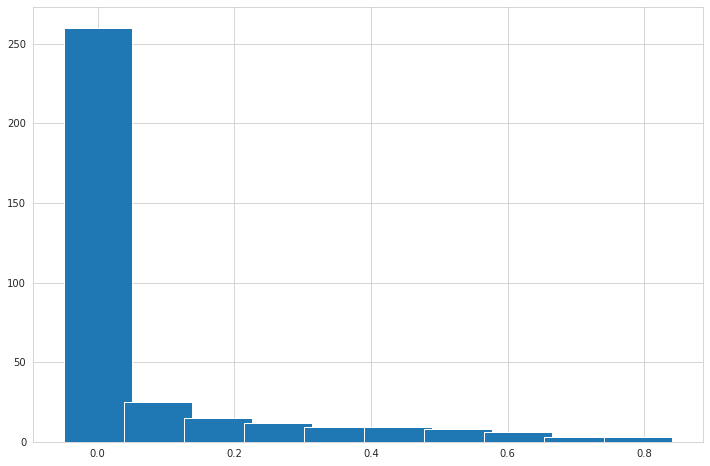



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8971428571428571
AUC Score:	0.8593418259023355

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9	0.8085714285714286	0.6828571428571428	
Cohen's Kappa:	0.39072913558141853	0.32150917192292117	0.249971041352948	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9319              0.9586              0.9451              314                 
1                   0.5185              0.3889              0.4444              36                  
avg/total           0.7252              0.6737              0.6947              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9557              0.8248              0.8855              3

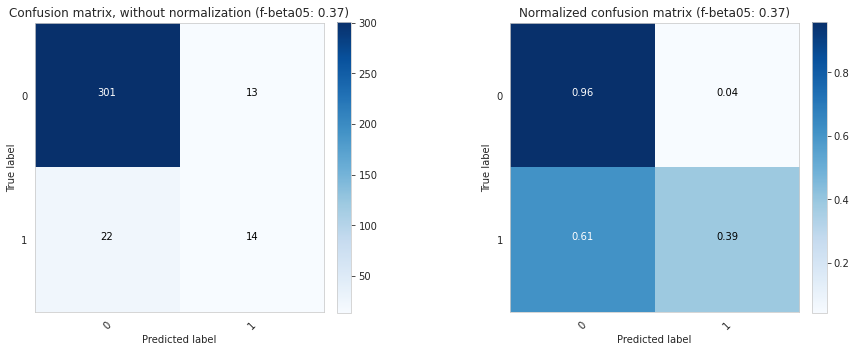

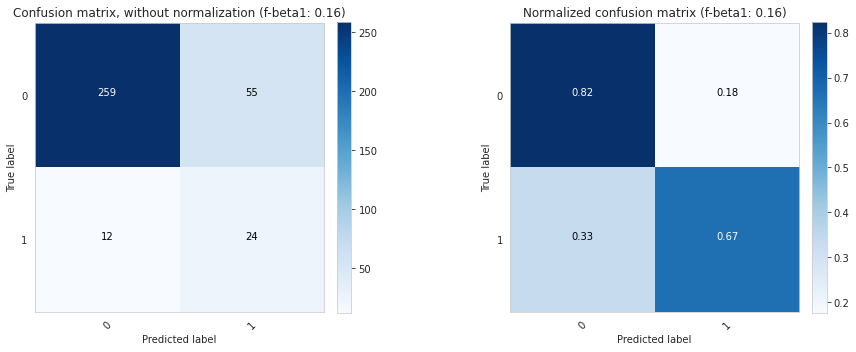

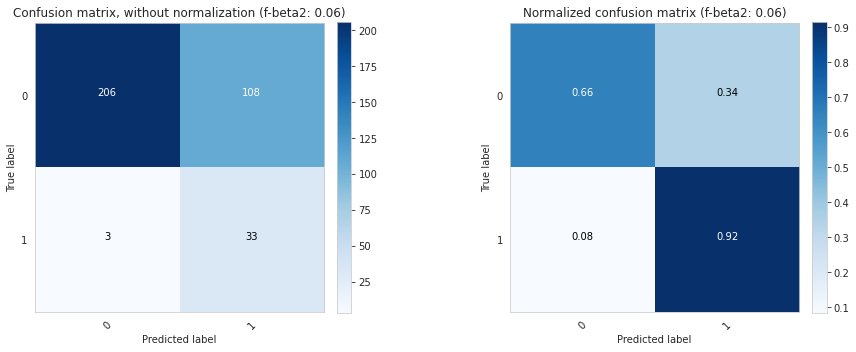



ROC Curve:


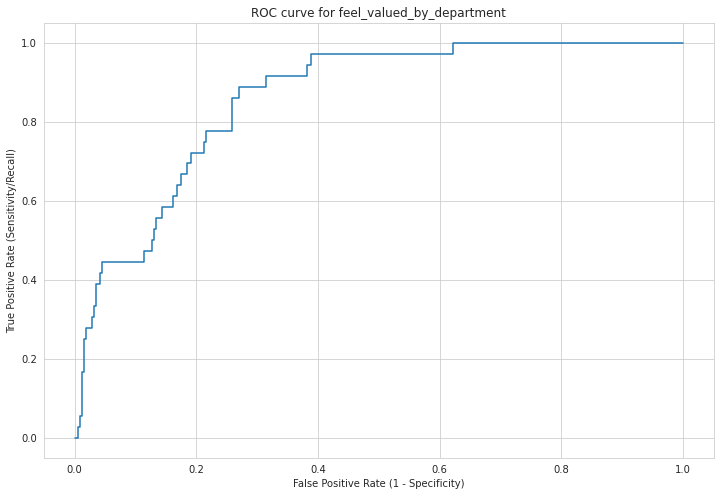

Predicted Probability Distribution:


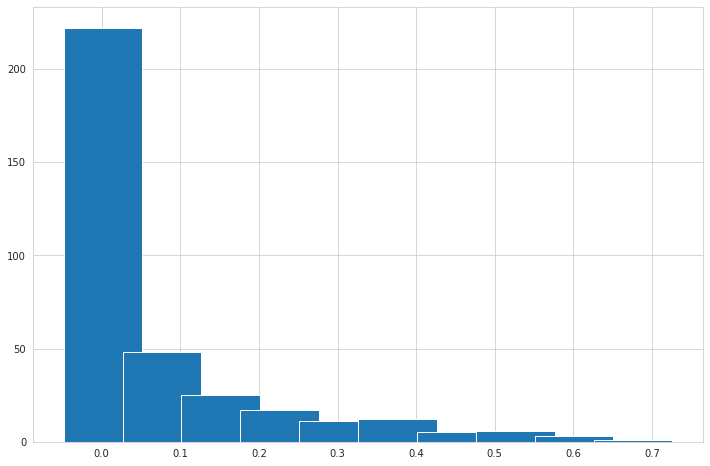



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.9628571428571429
AUC Score:	0.9522939968043825

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9657142857142857	0.9628571428571429	0.9485714285714286	
Cohen's Kappa:	0.5536663124335812	0.6103784894673745	0.5482575648931594	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9851              0.9792              0.9821              337                 
1                   0.5333              0.6154              0.5714              13                  
avg/total           0.7592              0.7973              0.7768              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9939              0.9674              0.9

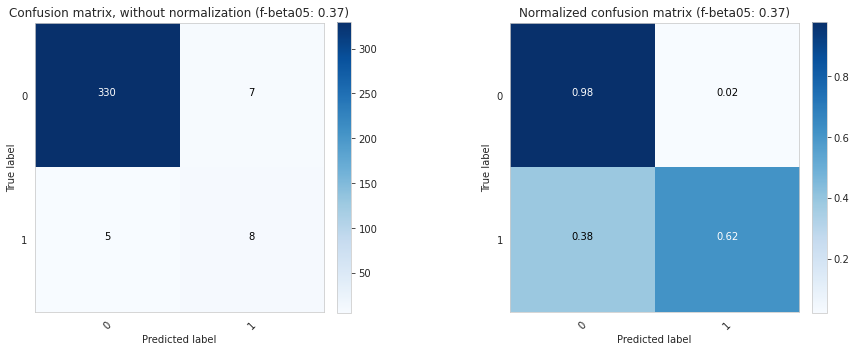

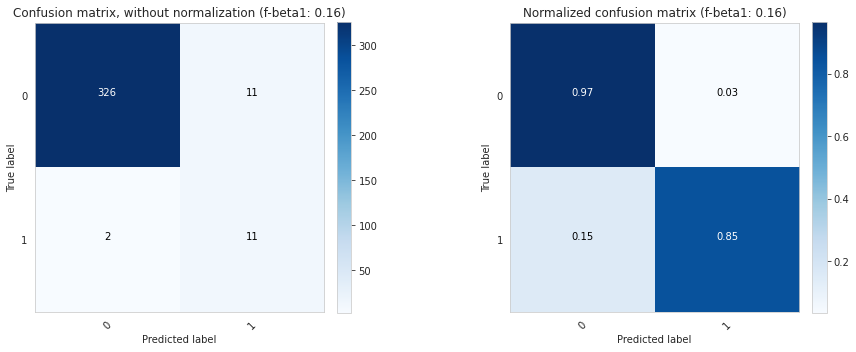

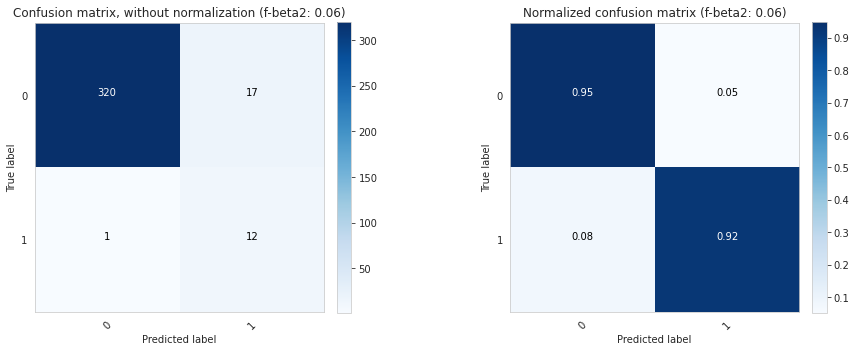



ROC Curve:


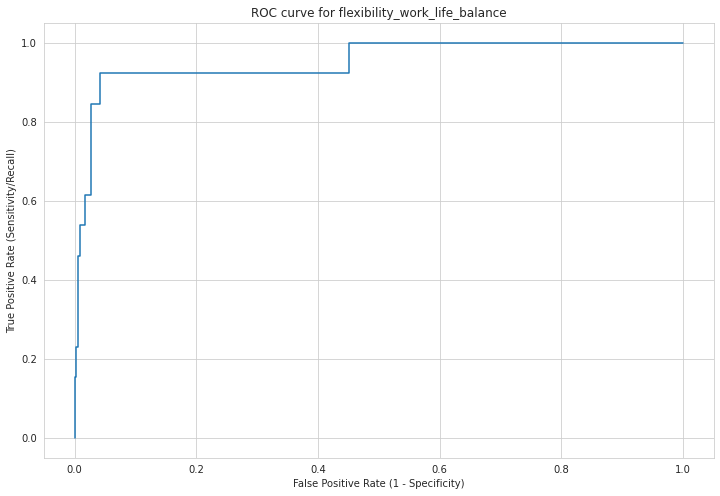

Predicted Probability Distribution:


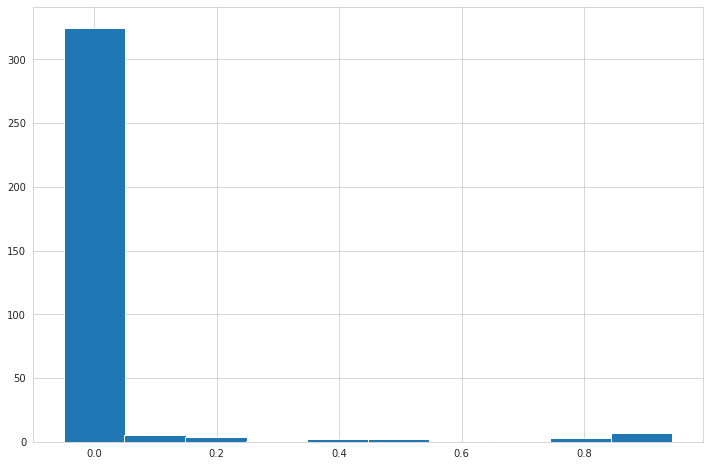



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.98
AUC Score:	0.7671803415243648

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9828571428571429	0.9657142857142857	0.92	
Cohen's Kappa:	0.3927125506072875	0.23273657289002558	0.09677419354838712	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9856              0.9971              0.9913              343                 
1                   0.6667              0.2857              0.4                 7                   
avg/total           0.8261              0.6414              0.6957              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9853              0.9796              0.9825              343                 

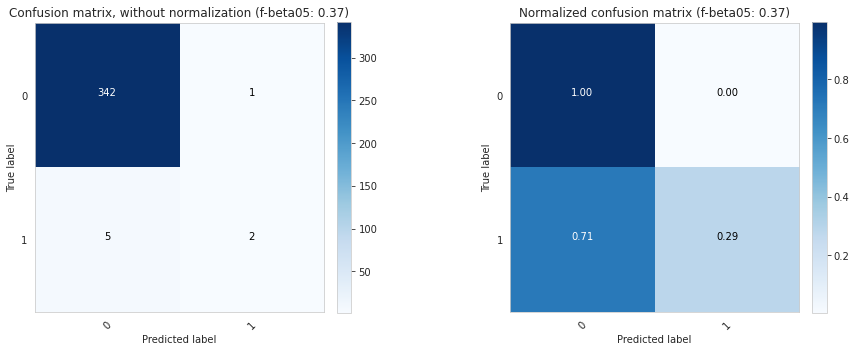

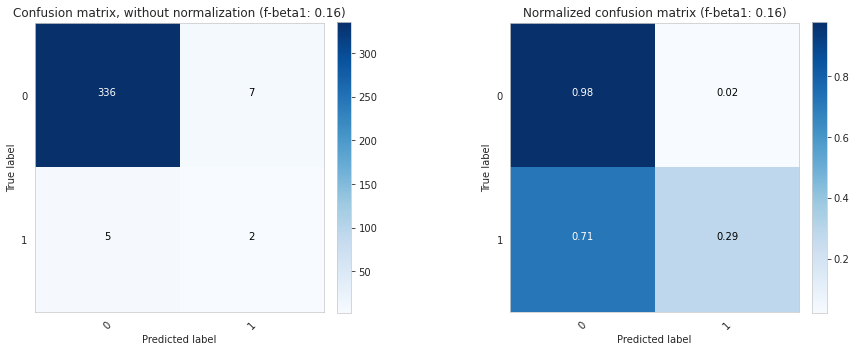

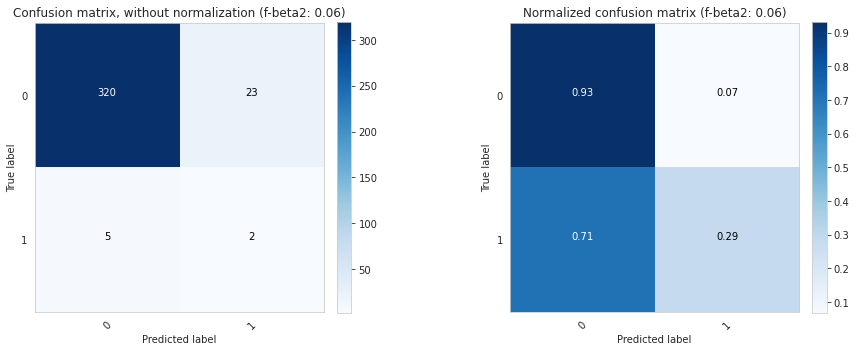



ROC Curve:


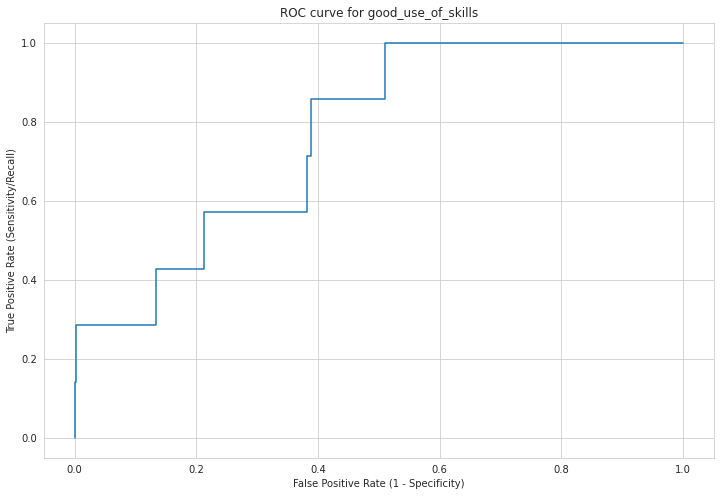

Predicted Probability Distribution:


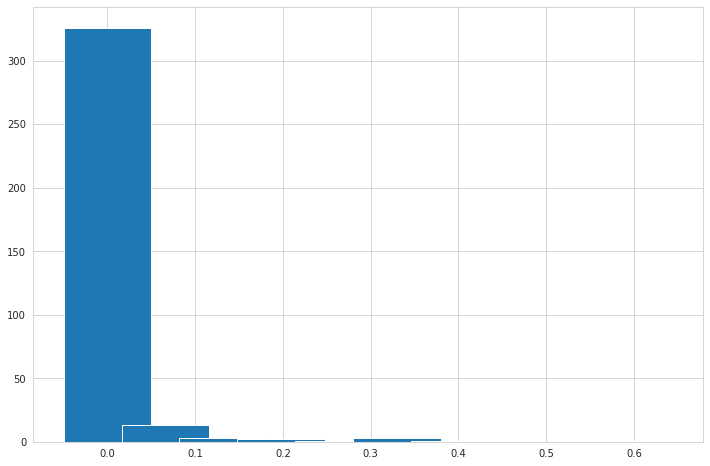



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.9771428571428571
AUC Score:	0.9557748538011697

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9828571428571429	0.98	0.9714285714285714	
Cohen's Kappa:	0.5628642797668609	0.578022735101619	0.5318352059925093	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9884              0.9942              0.9913              342                 
1                   0.6667              0.5                 0.5714              8                   
avg/total           0.8275              0.7471              0.7813              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9912              0.9883              0.9898              342    

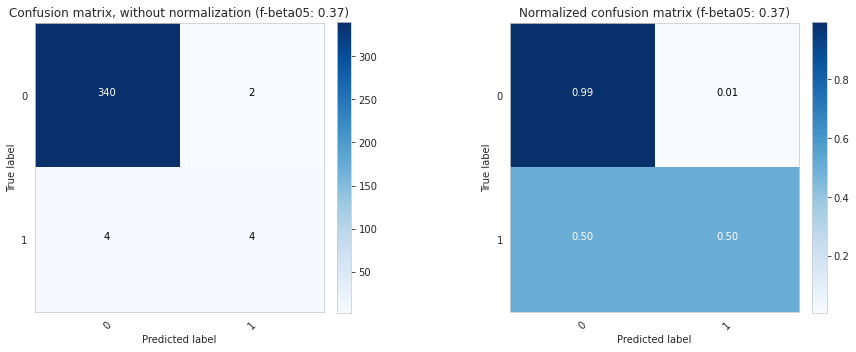

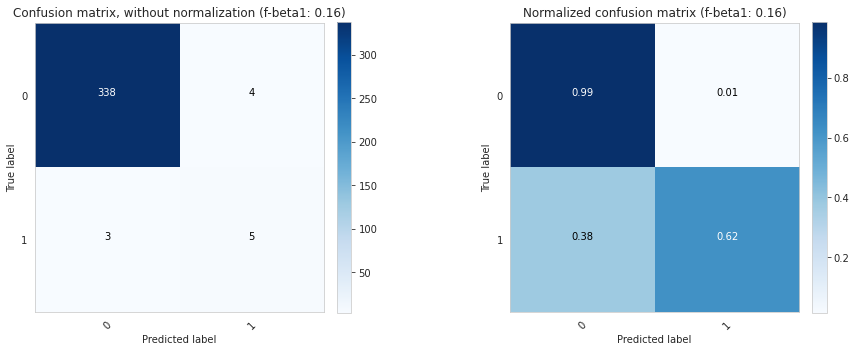

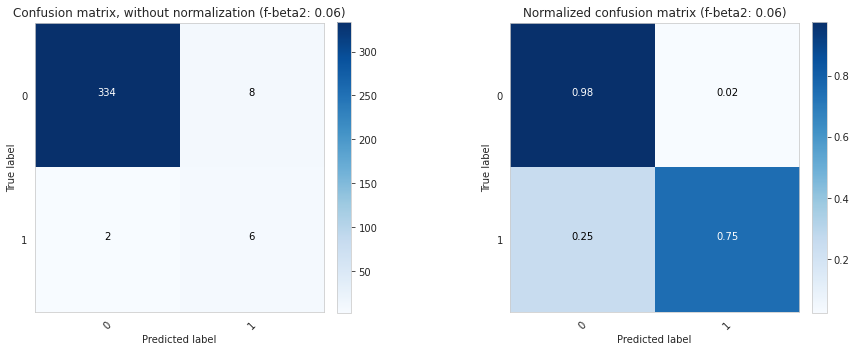



ROC Curve:


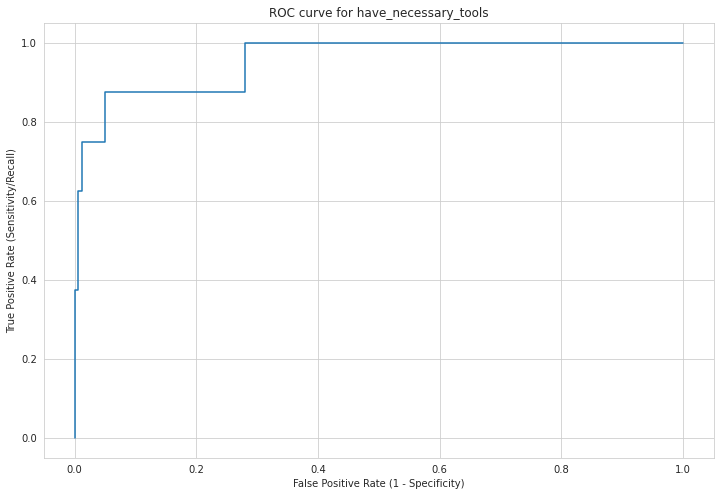

Predicted Probability Distribution:


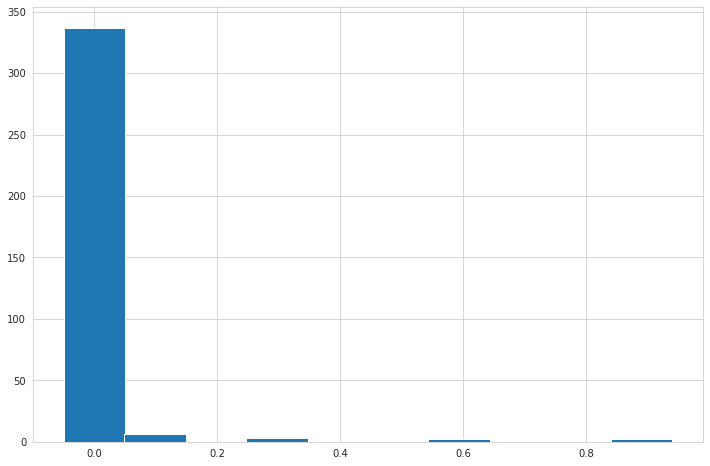



----------------------------------------------------------------------------------------------------


HAVE_VOICE_WITHIN_MY_INSTITUTION_VALUED_MEMBER_OF_MY_INSTITUTION

Null Accuracy:	0.9228571428571428
AUC Score:	0.8536865038413026

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9257142857142857	0.8885714285714286	0.7714285714285715	
Cohen's Kappa:	0.2102065613608749	0.30050220354617196	0.23047325894574844	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9329              0.9907              0.961               323                 
1                   0.5714              0.1481              0.2353              27                  
avg/total           0.7522              0.5694              0.5981              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9494

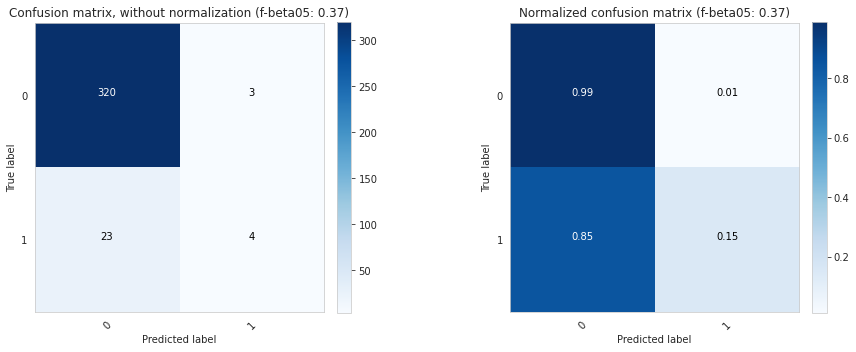

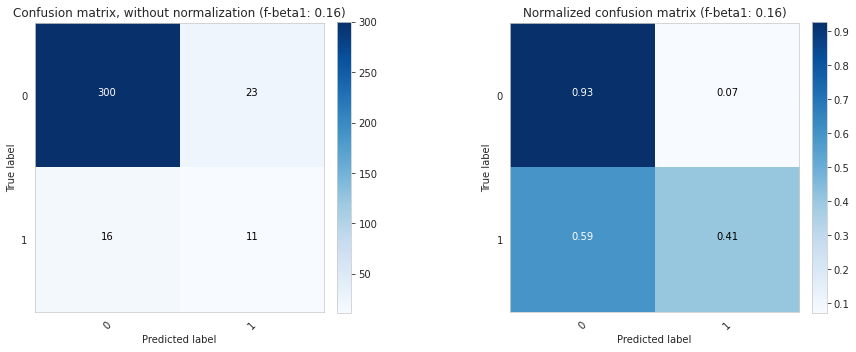

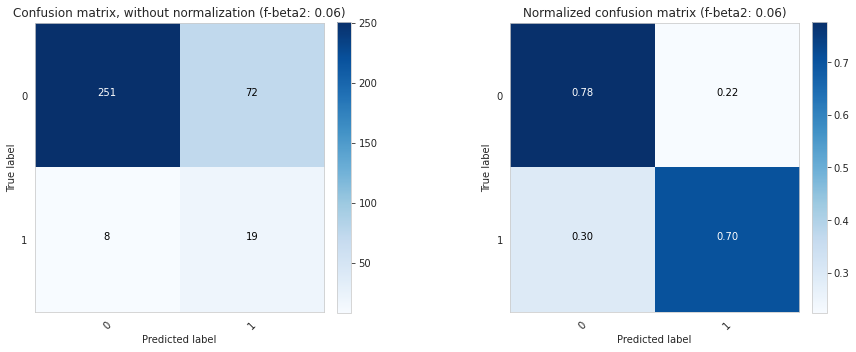



ROC Curve:


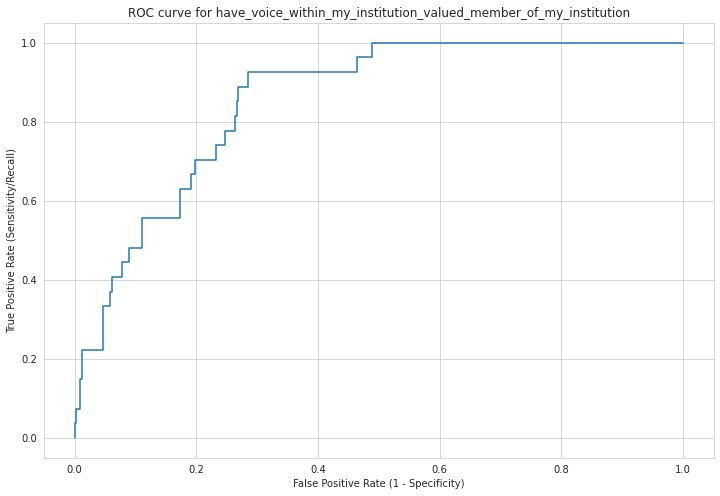

Predicted Probability Distribution:


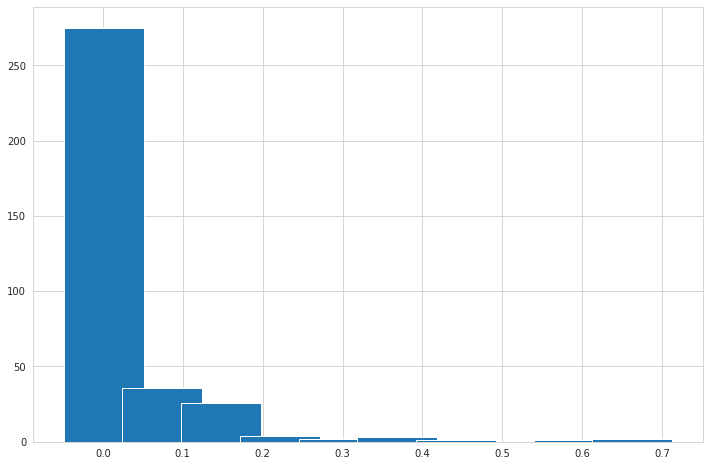



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.9571428571428572
AUC Score:	0.9482587064676617

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9571428571428572	0.9371428571428572	0.8257142857142857	
Cohen's Kappa:	0.42244224422442245	0.4924192485168095	0.24531636620714026	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9734              0.9821              0.9777              335                 
1                   0.5                 0.4                 0.4444              15                  
avg/total           0.7367              0.691               0.7111              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9906              0.9433              0.

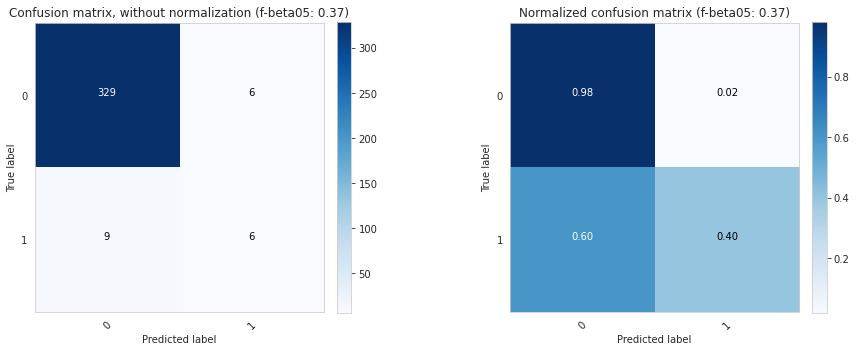

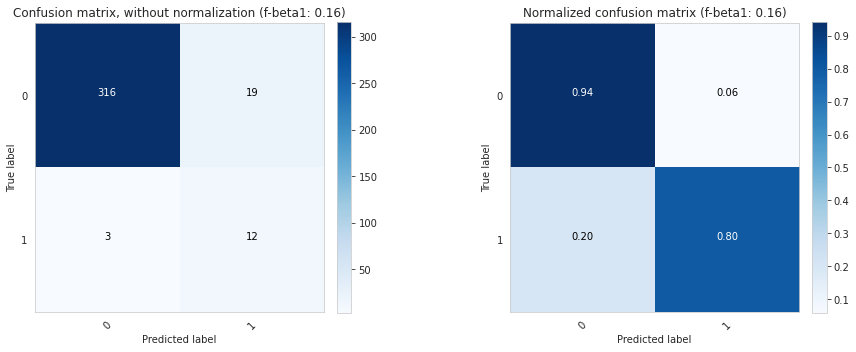

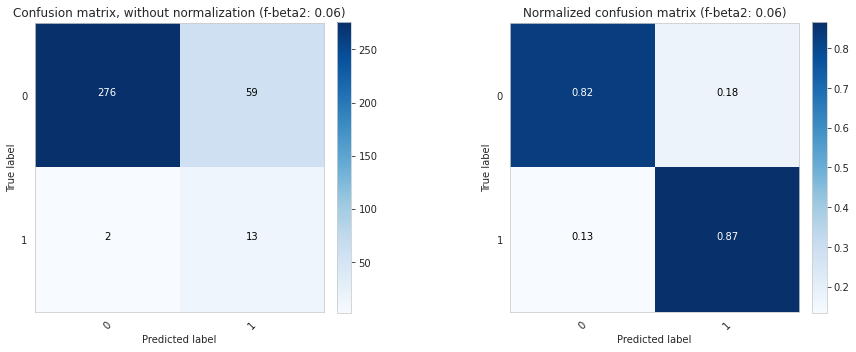



ROC Curve:


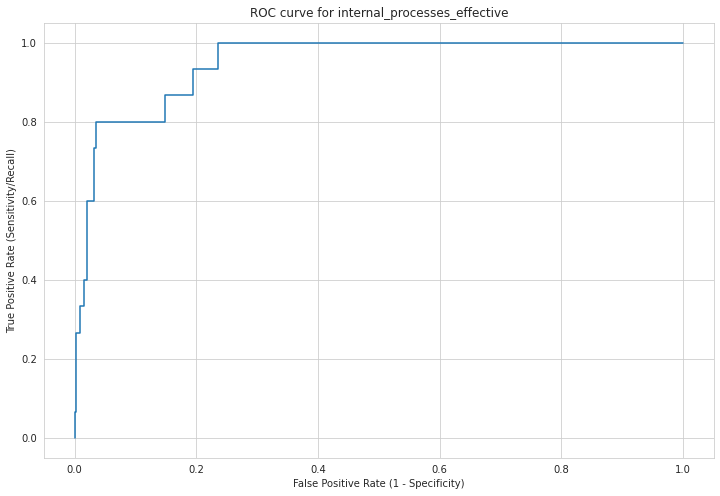

Predicted Probability Distribution:


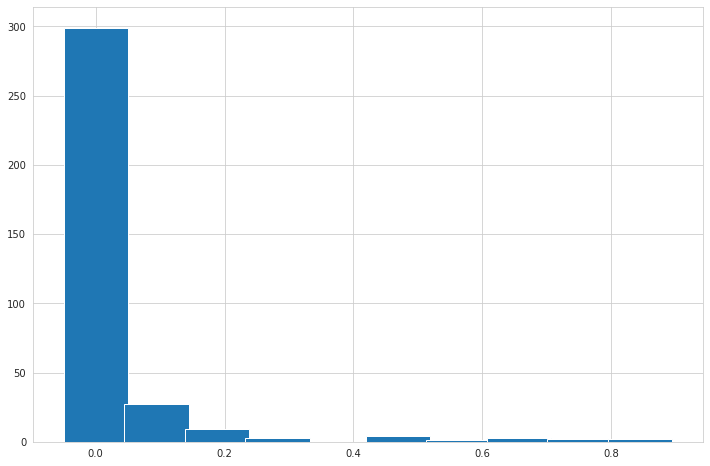



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9771428571428571
AUC Score:	0.9919590643274854

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.98	0.9771428571428571	0.98	
Cohen's Kappa:	0.6569588350602072	0.6254681647940075	0.6862996158770807	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.997               0.9825              0.9897              342                 
1                   0.5385              0.875               0.6667              8                   
avg/total           0.7677              0.9287              0.8282              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.997               0.9795              0.9882              342               

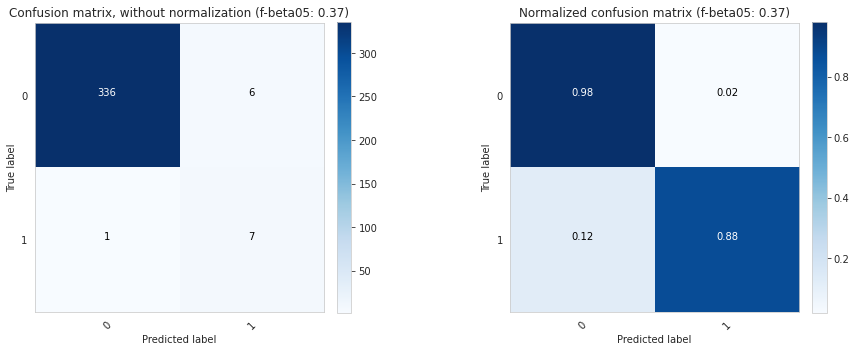

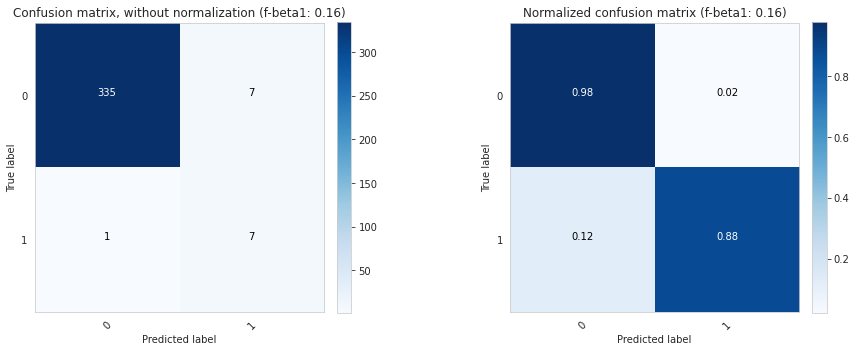

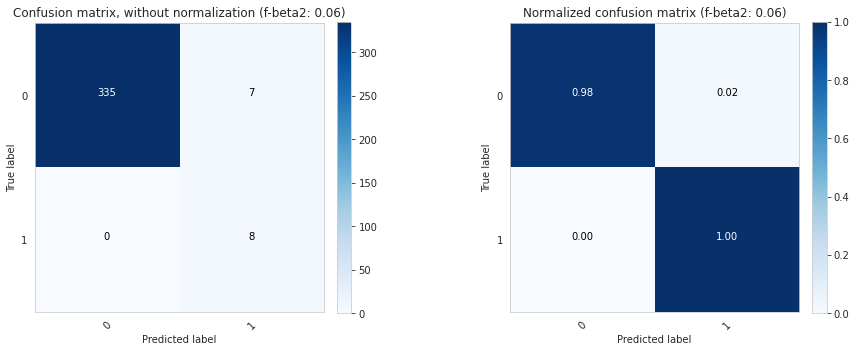



ROC Curve:


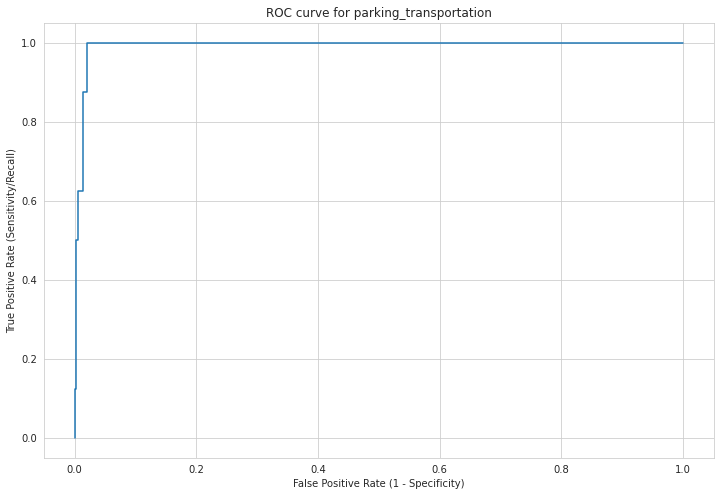

Predicted Probability Distribution:


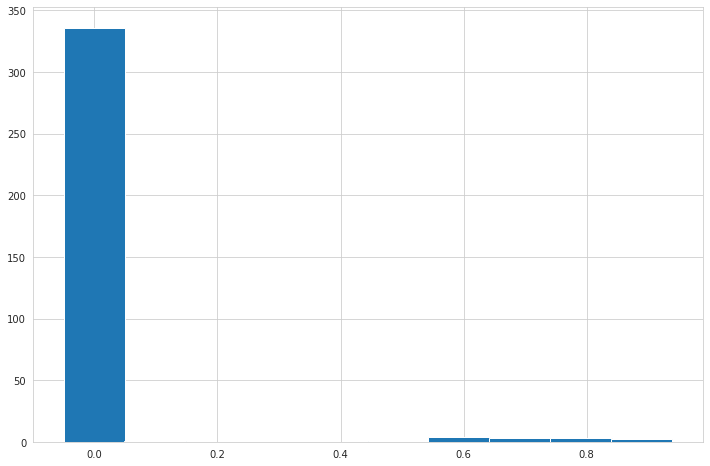



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.9142857142857143
AUC Score:	0.9363541666666666

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9028571428571428	0.8571428571428571	0.8371428571428572	
Cohen's Kappa:	0.5126945126945127	0.43181818181818177	0.4229100376048597	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9735              0.9188              0.9453              320                 
1                   0.4583              0.7333              0.5641              30                  
avg/total           0.7159              0.826               0.7547              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9821              0.8594              0.9167              3

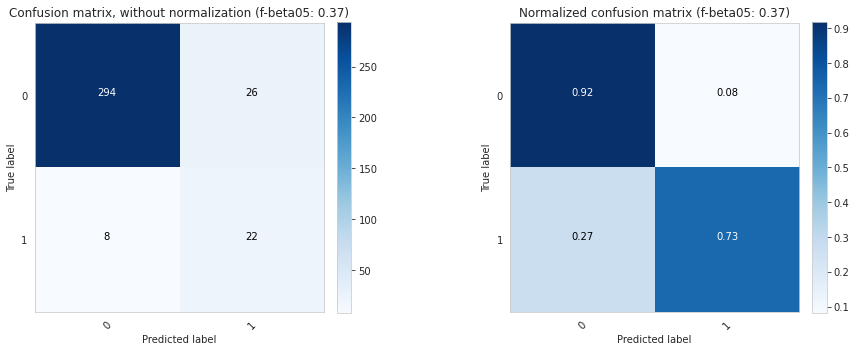

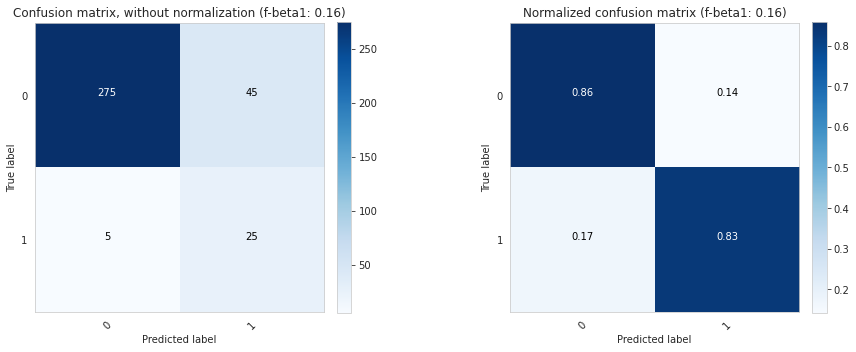

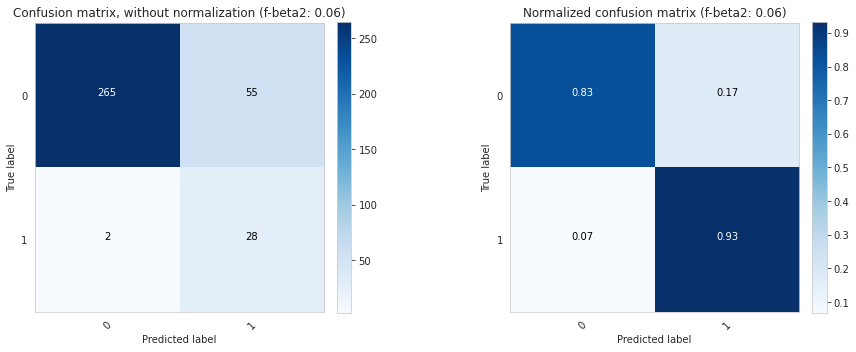



ROC Curve:


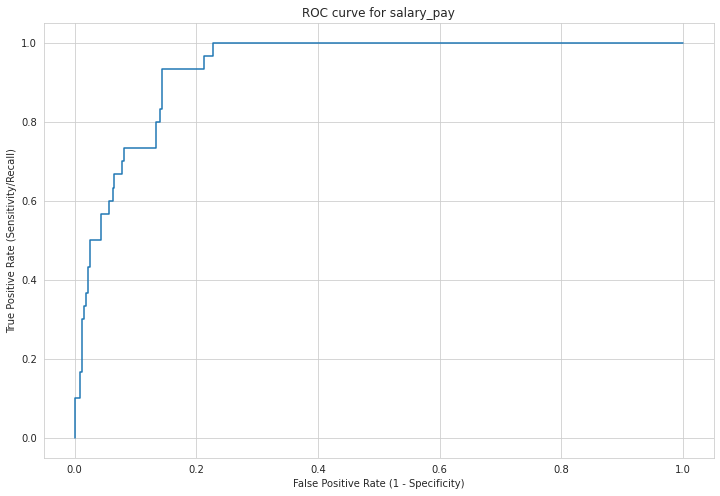

Predicted Probability Distribution:


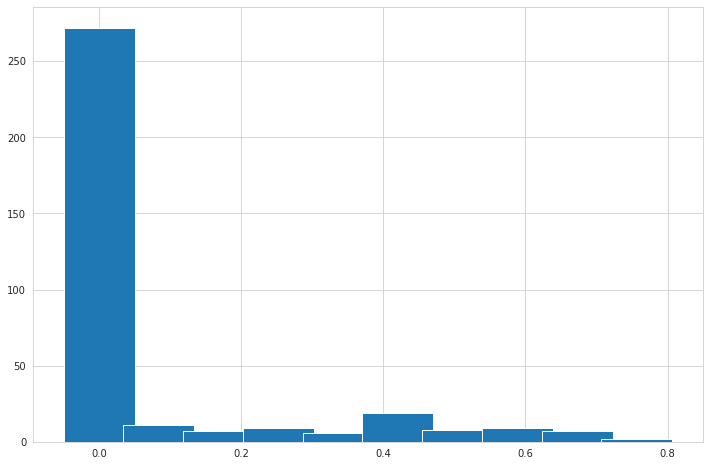



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.9228571428571428
AUC Score:	0.828689370485036

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.9171428571428571	0.86	0.7342857142857143	
Cohen's Kappa:	0.3641147725848891	0.2750866514498267	0.20271395679224025	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9482              0.9628              0.9555              323                 
1                   0.4545              0.3704              0.4082              27                  
avg/total           0.7014              0.6666              0.6818              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9536              0.8916              0.9216        

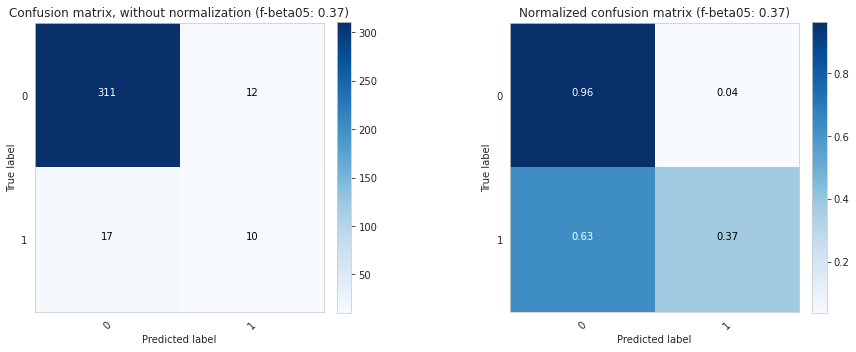

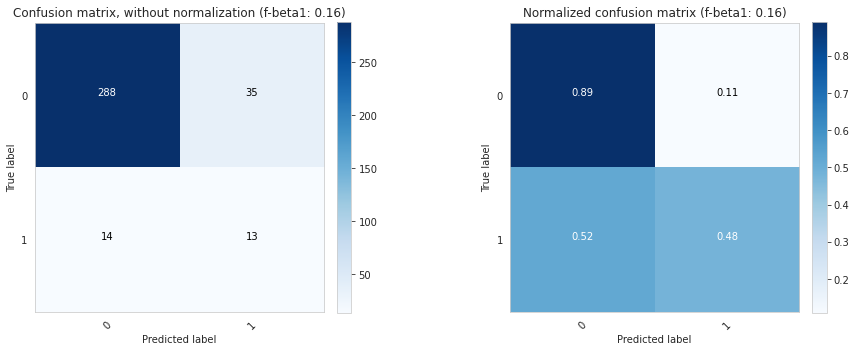

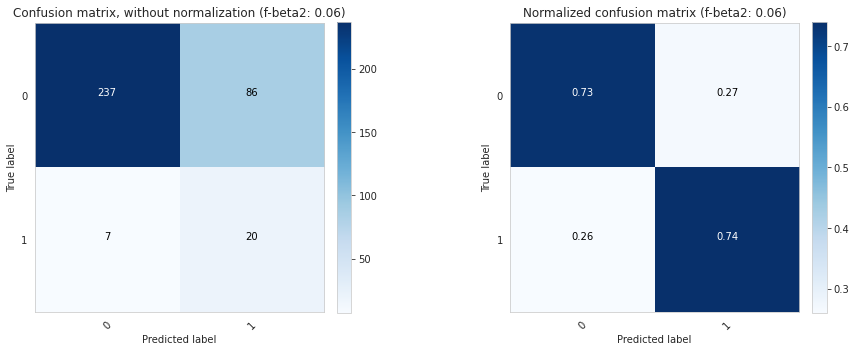



ROC Curve:


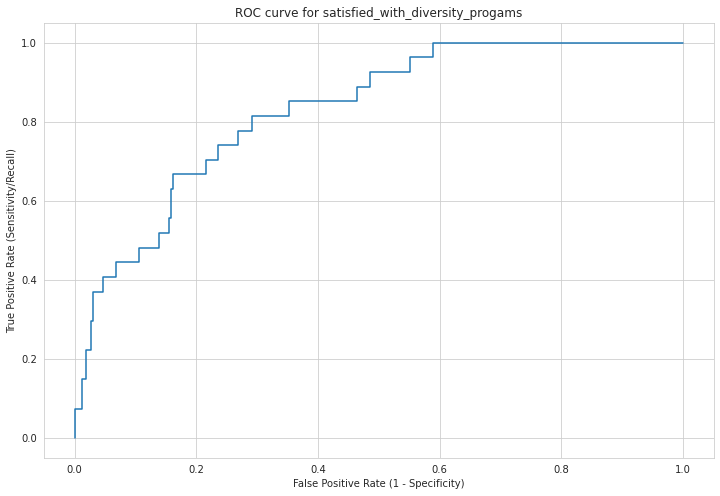

Predicted Probability Distribution:


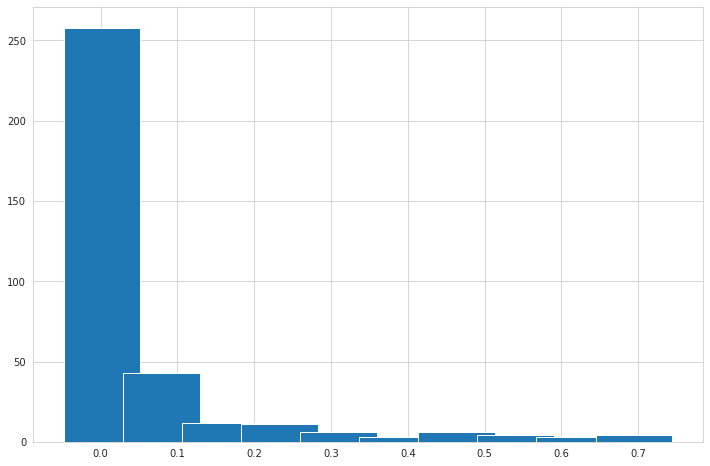



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8914285714285715
AUC Score:	0.808029689608637

		f-beta05(0.37)		f-beta1(0.16)		f-beta2(0.06)
Accuracy:	0.88	0.8228571428571428	0.6771428571428572	
Cohen's Kappa:	0.33387710712343666	0.2962770787391361	0.2048972699127498	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9245              0.9423              0.9333              312                 
1                   0.4375              0.3684              0.4                 38                  
avg/total           0.681               0.6554              0.6667              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9371              0.859               

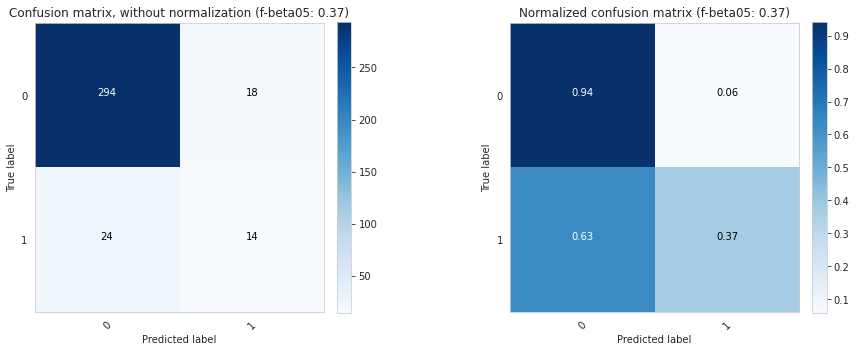

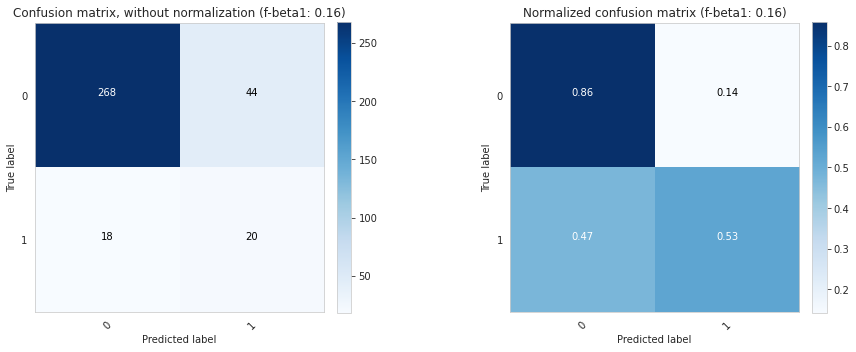

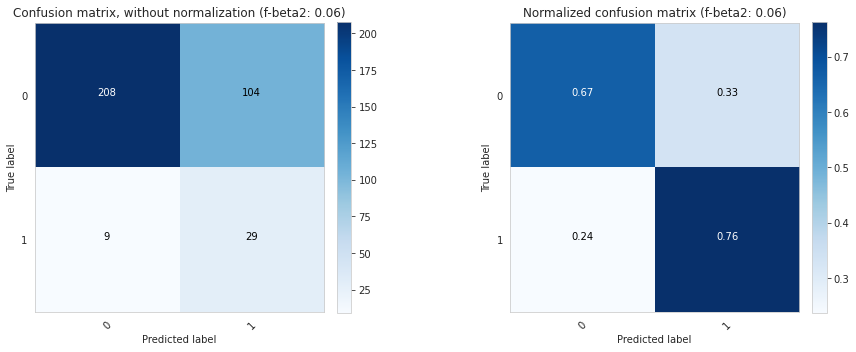



ROC Curve:


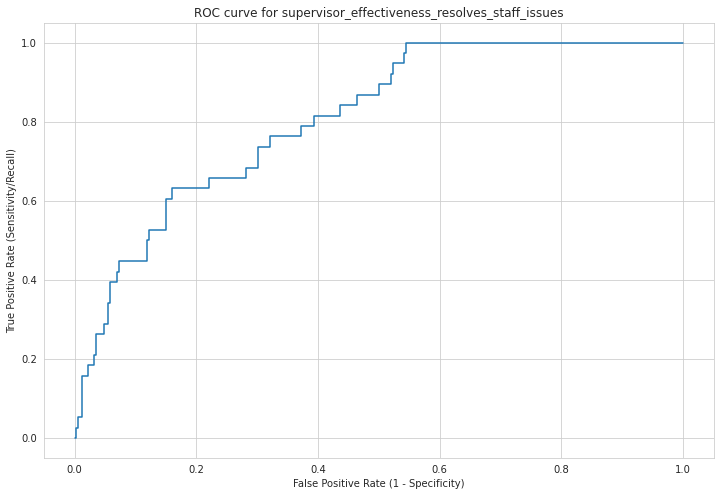

Predicted Probability Distribution:


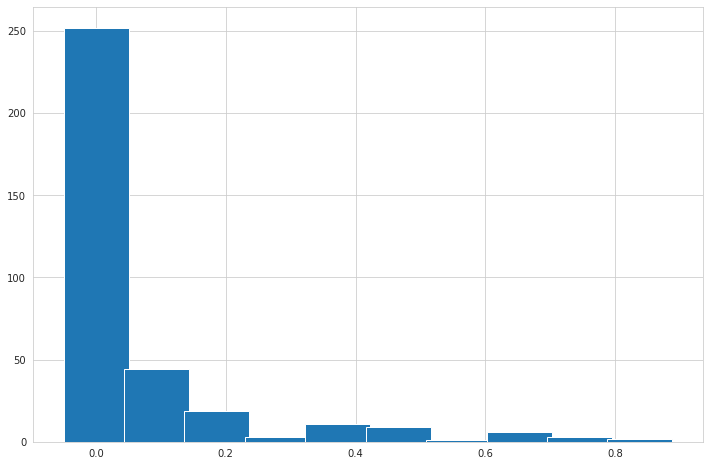



----------------------------------------------------------------------------------------------------




In [69]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards (optional) passes

In [70]:
try:
    inf_learn.purge(); inf_learn = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')
dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [71]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [72]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

(torch.Size([350, 25]), torch.Size([350, 25]), torch.Size([350]))

### Results

In [73]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [74]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.37000000000000005 0.16000000000000003 0.060000000000000005
Fowards Only
-------------
f05:	Optimal threshold = 0.37000000000000005	(Accuracy = 0.9307428598403931)
f1:	Optimal threshold = 0.16000000000000003	(Accuracy = 0.9001142978668213)
f2:	Optimal threshold = 0.060000000000000005	(Accuracy = 0.8288000226020813)

Accuracy: 0.9362285733222961


In [75]:
final_valid_loss = loss.mean().item()

## Codify our training/eval loop and score reporting

In [76]:
#export
def train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={}):
          
    config = {**saw_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    df = get_saw_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    dls = get_saw_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config)
    
    learn, fit_cbs = get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, train_config=config)
    
    with learn.no_logging(): 
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(5, lr_max=lr_min, cbs=fit_cbs)
        
        learn.unfreeze()
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model)
        learn.export(fname=config['export_filename'])
        
    # ===== fetch scores, probs, targs, losses, and optional f-scores/thresholds ====
    learn = learn.load(config['save_model_filename'])
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
    # determine optimal threshold based on desired f-score
    average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

    f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)

    scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}
    
    scores['f05']['threshold'] = f05.opt_th(probs, targs)
    scores['f1']['threshold'] = f1.opt_th(probs, targs)
    scores['f2']['threshold'] = f2.opt_th(probs, targs)
    
    scores['f05']['score'] = f05.opt_fscore(probs, targs)
    scores['f1']['score'] = f1.opt_fscore(probs, targs)
    scores['f2']['score'] = f2.opt_fscore(probs, targs)
    
    # save scores from validation set
    yyyymmdd = datetime.today().strftime("%Y%m%d")
          
    with open(f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl", 'wb') as f:
        pickle.dump(scores, f)
        
    # save train/validation probs, targs, losses for review
    test_dl = dls.test_dl(df, with_labels=True)
    probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
    
    probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
    targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
    losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
    final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)
    
    final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_train_results{m_suf}.csv", index=False)
        
    return scores, final_df

In [77]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_SAW_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.3250152616721392.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.39527721346348677.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with precision_score value: 0.5214785139775368.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


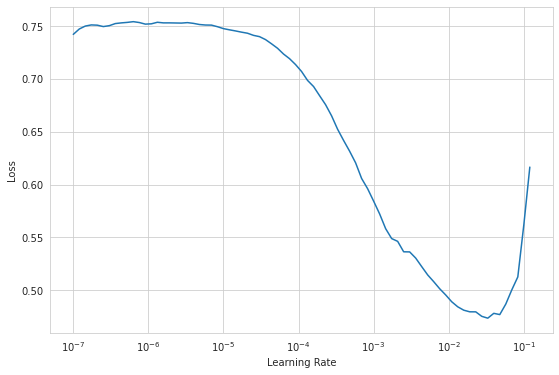

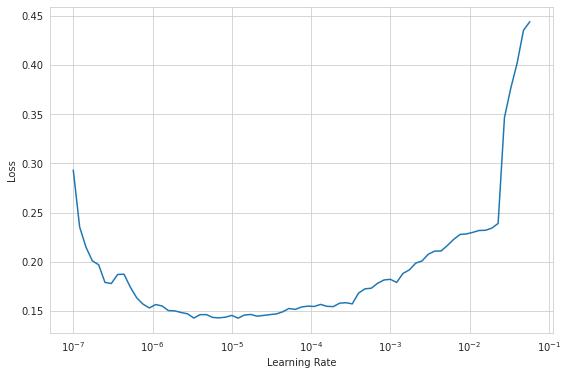

In [78]:
scores, train_res_df = train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={})

In [79]:
scores

{'valid_loss': 0.17250555753707886,
 'accuracy_multi': 0.9289144277572632,
 'fbeta_score': 0.4300613951938706,
 'precision_score': 0.4754193963419939,
 'recall_score': 0.4020797227036395,
 'roc_auc_score': 0.6809240304393506,
 'opt_th': 0.2899999999999999,
 'f05': {'threshold': 0.31000000000000005, 'score': 0.4431436836377269},
 'f1': {'threshold': 0.15000000000000002, 'score': 0.4282999973236633},
 'f2': {'threshold': 0.07, 'score': 0.5624497466807595}}

In [80]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues,labels,is_valid,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,targ_adequate_staffing,targ_advancement_and_training_opportunities,targ_appropriate_stress_work_assigned_equitably,targ_benefits,targ_better_ways_recognized_participate_in_decisions,targ_career_advancement,targ_committed_to_diversity,targ_communicates_essential_information,targ_ethical_conduct_perform_responsibilities_spirit_of_cooperation,targ_evaluated_fairly,targ_experienced_discrimination,targ_facilities_workspace_safety,targ_faculty_value_contributions,targ_favoritism_cliques,targ_fear_of_retaliation_negative_consequences,targ_feel_valued_by_department,targ_flexibility_work_life_balance,targ_good_use_of_skills,targ_have_necessary_tools,targ_have_voice_within_my_institution_valued_member_of_my_institution,targ_internal_processes_effective,targ_parking_transportation,targ_salary_pay,targ_satisfied_with_diversity_progams,targ_supervisor_effectiveness_resolves_staff_issues,loss
0,0,588941,1877,I enjoy our department potlucks and social activities. I am grateful that our department leader...,NaN,English,212,9,SAW,UCSD,449396,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,24000.0,3834,999999.0,UC San Diego,8000.0,MARINE SCIENCES,24000.0,DIRECTORS OFFICE-SIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,committed_to_diversity feel_valued_by_department satisfied_with_diversity_progams,False,0.058777,0.002287,0.001942,0.001980,0.010408,0.001284,0.244724,0.002867,0.330904,0.002011,0.472257,0.011072,0.097734,0.112795,0.002621,0.230573,0.005708,0.009822,0.000057,0.011376,0.012054,0.000605,0.001040,0.41845

In [81]:
# load results
with open(STANDARD_THEME_SAW_PATH/'model_scores_multilabel_hf.pkl', 'rb') as f: training_results = pickle.load(f)
training_results

{'valid_loss': 0.17250555753707886,
 'accuracy_multi': 0.9289144277572632,
 'fbeta_score': 0.4300613951938706,
 'precision_score': 0.4754193963419939,
 'recall_score': 0.4020797227036395,
 'roc_auc_score': 0.6809240304393506,
 'opt_th': 0.2899999999999999,
 'f05': {'threshold': 0.31000000000000005, 'score': 0.4431436836377269},
 'f1': {'threshold': 0.15000000000000002, 'score': 0.4282999973236633},
 'f2': {'threshold': 0.07, 'score': 0.5624497466807595}}

In [82]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/'export_clas_multilabel_hf.pkl')
print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.2899999999999999


((#1) ['salary_pay'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False]), tensor([8.5487e-03, 5.7252e-03, 3.4633e-03, 2.4960e-01, 1.1246e-03, 6.0786e-03,
        6.0628e-03, 3.8199e-04, 6.2189e-03, 2.4051e-03, 4.8138e-04, 4.8223e-03,
        4.0408e-03, 1.2122e-04, 1.7316e-01, 1.3110e-02, 1.0269e-02, 1.0973e-03,
        2.2804e-03, 3.2220e-03, 8.8341e-03, 2.3184e-02, 7.3685e-01, 7.2910e-03,
        6.9358e-03]))


((#2) ['better_ways_recognized_participate_in_decisions','faculty_value_contributions'], tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([2.4554e-02, 3.3087e-03, 4.0888e-03, 3.3786e-04, 4.6474e-01, 3.6026e-04,
        3.1325e-03, 1.3409e-03, 1.7072e-01, 3.8691e-03, 2.0158e-02, 1.5449e-03,
        8.0975e-01, 6.8884e-04, 3.8116e-03, 1.6545e-01, 2.8123e-04, 4.9694e-03,
        1.7869e-04, 5.3303e-02, 3.3914e-03, 1.7793e-03, 5.9807e-03, 3.2286e-02,
        2.5764e-02]))


## Inference

### Inference (ad-hoc documents)

In [83]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [84]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([   0, 1491, 1199,  615,    4,    2]), (#1) ['salary_pay'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False]), tensor([4.4452e-03, 1.8094e-02, 1.1101e-03, 5.7886e-03, 2.6502e-03, 4.8937e-03,
        9.4818e-03, 3.7490e-04, 6.8481e-03, 8.5915e-03, 4.7734e-04, 2.7407e-03,
        3.3056e-03, 1.1665e-03, 1.4436e-01, 1.2089e-02, 4.8432e-04, 2.3978e-03,
        8.0853e-04, 5.6687e-03, 8.3764e-03, 1.5400e-02, 8.0106e-01, 4.3029e-03,
        6.6799e-03]))


(HF_BaseInput([    0,    38,   524, 10028,    19,   127,  1795,     8,    52,    33,
          615,    82,    11,   127,  1494,     4,    20,  7998,    16,  1266,
            7,   162,     4,     2]), (#2) ['better_ways_recognized_participate_in_decisions','faculty_value_contributions'], tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([4.2649e-02, 2.0529e-03, 4.0482e-03, 2.0155e-02, 3.8112e-01, 6.0718e-04,
        5.4862e-03, 1.0095e-03, 7.1168e-02, 3.8473e-03, 1.7870e-02, 2.1595e-03,
        6.0294e-01, 1.1572e-03, 1.5383e-02, 2.3274e-01, 6.8684e-04, 4.0484e-03,
        1.9189e-04, 4.1289e-02, 2.6046e-03, 2.1548e-03, 2.4815e-02, 4.4708e-02,
        1.8883e-02]))


(HF_BaseInput([    0,    38,   657, 10017,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([1.0563e-02, 4.6397e-04, 6.5083e-04, 6.2013e-03, 2.0139e-03, 5.6694e-04,
        2.3586e-02, 8.4864e-05, 2.3818e-01, 9.2326e-04, 8.2532e-02, 3.0877e-03,
        3.2683e-02, 1.3856e-03, 3.5701e-03, 1.9759e-01, 1.8557e-03, 8.3871e-03,
        1.7566e-05, 1.0655e-02, 9.0253e-04, 2.9570e-04, 2.4807e-03, 5.2930e-02,
        3.9769e-03]))


(HF_BaseInput([    0,    38,    64,   393,   465,    10,  2932,  1514,     4,    20,
         2572,    90,  1634,    32,    45,    15,    86,     4, 10310,     2]), (#1) ['parking_transportation'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False]), tensor([1.0343e-02, 5.8327e-03, 4.2411e-03, 2.6534e-04, 1.4310e-03, 2.7682e-03,
        4.8761e-03, 1.6525e-05, 1.8706e-02, 6.3229e-04, 6.0324e-03, 9.9118e-03,
        7.9289e-03, 1.5782e-03, 2.2879e-03, 7.3344e-03, 2.6348e-02, 4.3397e-03,
        4.8758e-04, 6.0961e-03, 2.1545e-02, 9.8664e-01, 3.7639e-03, 2.8203e-03,
        4.3298e-03]))


(HF_BaseInput([    0,    38,    21,   269,  9800,     7,  5486,   127,  2979, 16506,
            2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]), tensor([9.5949e-04, 5.0786e-03, 8.9445e-04, 1.8111e-03, 2.3490e-02, 6.3801e-03,
        3.1063e-02, 9.8277e-04, 5.5981e-02, 2.0152e-03, 1.8612e-01, 2.3193e-03,
        3.5404e-03, 6.8617e-04, 6.0183e-02, 2.0024e-01, 4.1900e-04, 8.5298e-03,
        1.0243e-04, 3.1378e-02, 9.1581e-04, 2.3137e-04, 1.4383e-02, 3.7533e-02,
        4.4347e-03]))


(HF_BaseInput([    0,  2321,  8914,   890,    16,    41,  9297,   884,     4,  1437,
           91,    34,  1613,  1065,     8,  1684,     7,  1045,    10,  1313,
          447,  1737,     8,   694,   434,  1616,     4,  1437,   832,  2720,
            7,    39,   165,    16,   542, 27978,   196,     8, 19781,   868,
            4, 37457,   338, 37457,   282, 37457,   338, 37457,   282, 38334,
         3144,  5302,  2478,    16,    10,  1421,     9, 12757,  1673,    13,
         6919,     8, 37513,  1630,  2617,  1820,     4,  1437,   264,    34,
         2208,     5,  2098,     9,   167,    79,  3315,   149,  5322,  4358,
            6, 17805,     6,     8, 13557,  9434,     4,     2]), (#2) ['faculty_value_contributions','supervisor_effectiveness_resolves_staff_issues'], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True]), tensor([2.8435e

### Inference (batch)

In [88]:
#export
def get_standard_theme_preds(inf_df, learner_export_path=None, model_scores_path=None,
                             device=torch.device('cpu'), train_config={}):
    
    config = {**saw_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): learner_export_path = f"{config['learner_path']}/{config['export_filename']}"
    if (model_scores_path is None): model_scores_path = f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl"
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. add model scores
    with open(model_scores_path, 'rb') as f: training_results = pickle.load(f)
    
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in STANDARD_THEME_SAW_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['f05']['threshold']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    inf_learn, inf_dl = None, None; gc.collect()
    
    return final_df, all_probs, STANDARD_THEME_SAW_LABELS

In [89]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

591447 4045


In [90]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_standard_theme_preds(inf_df, device=device)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

cuda:1
0
(4045, 102) torch.Size([4045, 25]) 25


In [91]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.093086,0.194305,0.007521,0.000877,0.130327,0.016501,0.033908,0.002817,0.167593,0.022677,0.005074,0.028991,0.086035,0.008903,0.013456,0.041299,0.002001,0.021882,0.000519,0.159780,0.115464,0.000048,0.002064,0.069693,0.214992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.172506,0.928914,0.430061,0.475419,0.40208,0.680924,0.29,0.31,0.443144,0.15,0.4283,0.07,0.56245
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BU

In [92]:
yyyymmdd = datetime.today().strftime("%Y%m%d")
preds_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_test_predictions{m_suf}.csv', index=False)

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [93]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues
0,0.093086,0.194305,0.007521,0.000877,0.130327,0.016501,0.033908,0.002817,0.167593,0.022677,0.005074,0.028991,0.086035,0.008903,0.013456,0.041299,0.002001,0.021882,0.000519,0.159780,0.115464,0.000048,0.002064,0.069693,0.214992
1,0.028435,0.011061,0.019453,0.000276,0.036834,0.025367,0.009634,0.005776,0.124546,0.011594,0.047104,0.002415,0.693558,0.012417,0.013432,0.126296,0.002046,0.006503,0.001184,0.021589,0.002251,0.000010,0.001596,0.030920,0.560251
2,0.027874,0.005952,0.002903,0.000246,0.211678,0.001453,0.084641,0.002109,0.111951,0.018298,0.110885,0.002743,0.677105,0.080588,0.022740,0.181965,0.000143,0.003463,0.000005,0.028206,0.001735,0.002175,0.002896,0.012131,0.054549
3,0.134677,0.001133,0.003744,0.003500,0.003000,0.003583,0.038860,0.000997,0.140578,0.002777,0.186877,0.004355,0.592586,0.004707,0.002228,0.232651,0.002283,0.001844,0.000335,0.014745,0.001977,0.000152,0.000400,0.050279,0.154373
4,0.011277,0.002545,0.001475,0.000410,0.008024,0.004394,0.023316,0.000946,0.185391,0.010075,0.079999,0.004529,0.014439,0.018725,0.012444,0.031467,0.000112,0.001988,0.000095,0.004221,0.000444,0.000398,0.001024,0.004842,0.418397


In [94]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [95]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f05).astype(np.int64)

In [96]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.093086,0.194305,0.007521,0.000877,0.130327,0.016501,0.033908,0.002817,0.167593,0.022677,0.005074,0.028991,0.086035,0.008903,0.013456,0.041299,0.002001,0.021882,0.000519,0.159780,0.115464,0.000048,0.002064,0.069693,0.214992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BUILDING AND CUSTODIAL SERVICES TOTAL STAFF,473.0,BUILDING & CUSTODIAL SERVICES MGRS/ADMIN,NaN,NaN,NaN,NaN,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,0.028435,0.011061,0.019453,0.000276,0.036834,0.02

## Cleanup

In [97]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [98]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_faculty_value_contributions', 'pred_supervisor_effectiveness_resolves_staff_issues']

=== probs ===
[0.6935578, 0.5602514]
